# Kaggle dataset extractor and organizer

In [4]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/afons/.kaggle/'

import zipfile
import pandas as pd
import kaggle
from docx import Document

### Remove feather files, if they exist

In [9]:
data_folder = 'data'

# List all files in the data folder
files = os.listdir(data_folder)

# Remove Feather files (files with a ".feather" extension)
for file in files:
    if file.endswith(".feather"):
        file_path = os.path.join(data_folder, file)
        os.remove(file_path)
        print(f"Removed {file_path}")

print("Feather files removed from the 'data' folder.")

Removed data\Crime_Data_from_2010_to_2019_0.feather
Removed data\Crime_Data_from_2010_to_2019_1.feather
Removed data\Crime_Data_from_2010_to_2019_2.feather
Removed data\Crime_Data_from_2010_to_2019_3.feather
Removed data\Crime_Data_from_2010_to_2019_4.feather
Removed data\Crime_Data_from_2010_to_2019_5.feather
Removed data\Crime_Data_from_2010_to_2019_6.feather
Removed data\Crime_Data_from_2010_to_2019_7.feather
Removed data\Crime_Data_from_2010_to_2019_8.feather
Removed data\Crime_Data_from_2010_to_2019_9.feather
Removed data\Crime_Data_from_2020_to_Present.feather
Feather files removed from the 'data' folder.


## Download the kaggle dataset

In [10]:
# set the path to the dataset on Kaggle
dataset_path = 'sumaiaparveenshupti/los-angeles-crime-data-20102020'

# download the dataset to the data folder
kaggle.api.dataset_download_files(dataset_path, path='data')


## Extract the files from zip, get into feather files and remove csv and zip file

In [11]:

# set the path to the zip file
zip_path = 'data/los-angeles-crime-data-20102020.zip'

# extract all csv files from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

In [12]:
import csv
import os

# Create the "data" directory if it doesn't exist
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Specify the input CSV file and the number of partitions
input_file = 'data/Crime_Data_from_2010_to_2019.csv'
num_partitions = 10  # Change this to the desired number of partitions

# Initialize a list of output CSV writers and files
output_writers = []
output_files = []

# Open the input file
with open(input_file, 'r') as input_csv:
    # Create a CSV reader for the input file
    csv_reader = csv.reader(input_csv)

    # Read the CSV header
    header = next(csv_reader)

    # Open output CSV files and writers for each partition in the "data" directory
    for i in range(num_partitions):
        partition_file = os.path.join(data_dir, f'Crime_Data_from_2010_to_2019_{i}.csv')
        output_file = open(partition_file, 'w', newline='')
        output_files.append(output_file)
        output_writers.append(csv.writer(output_file))

        # Write the header to each output file
        output_writers[i].writerow(header)

    # Iterate through the input CSV and distribute rows to output partitions
    current_partition = 0
    for row in csv_reader:
        output_writers[current_partition].writerow(row)
        current_partition = (current_partition + 1) % num_partitions  # Cycle through partitions

# Close all output CSV files
for output_file in output_files:
    output_file.close()

print(f'Partitioned into {num_partitions} smaller CSV files in the "data" folder.')


Partitioned into 10 smaller CSV files in the "data" folder.


In [13]:
# iterate over all csv files in the data folder
for file_name in os.listdir('data'):
    if file_name.endswith('.csv'):
        print(f'Processing {file_name}...')
        # read the csv file into a pandas dataframe
        df = pd.read_csv(os.path.join('data', file_name))
        
        # transform the dataframe into more space-efficient datatypes
        for col in df.columns:
            if df[col].dtype == 'int64':
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif df[col].dtype == 'float64':
                df[col] = pd.to_numeric(df[col], downcast='float')
        
        # save the transformed dataframe as a feather file
        feather_path = os.path.join('data', os.path.splitext(file_name)[0] + '.feather')
        df.to_feather(feather_path)

Processing Crime_Data_from_2010_to_2019.csv...
Processing Crime_Data_from_2010_to_2019_0.csv...
Processing Crime_Data_from_2010_to_2019_1.csv...
Processing Crime_Data_from_2010_to_2019_2.csv...
Processing Crime_Data_from_2010_to_2019_3.csv...
Processing Crime_Data_from_2010_to_2019_4.csv...
Processing Crime_Data_from_2010_to_2019_5.csv...
Processing Crime_Data_from_2010_to_2019_6.csv...
Processing Crime_Data_from_2010_to_2019_7.csv...
Processing Crime_Data_from_2010_to_2019_8.csv...
Processing Crime_Data_from_2010_to_2019_9.csv...
Processing Crime_Data_from_2020_to_Present.csv...


In [10]:
# Specify the path to your PDF file
docx_path = 'data/MO_CODES_Numerical_20180627.docx'

# Load the Word document
doc = Document(docx_path)

# Create an empty list to store table data
table_data = []

# Iterate through tables in the document
for table in doc.tables:
    for row in table.rows:
        row_data = [cell.text.strip() for cell in row.cells]
        table_data.append(row_data)

# Convert the table data into a Pandas DataFrame
df = pd.DataFrame(table_data[1:], columns=table_data[0])

# Specify the path for the CSV file
csv_path = 'data/MO_CODES_Numerical_20180627.csv'

# Write the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f"CSV file saved at: {csv_path}")


CSV file saved at: data/MO_CODES_Numerical_20180627.csv


In [14]:
# delete the zip file and the csv files
os.remove('data/los-angeles-crime-data-20102020.zip')
for file_name in os.listdir('data'):
    if file_name.endswith('.csv'):
        os.remove(os.path.join('data', file_name))
os.remove('data/Crime_Data_from_2010_to_2019.feather')

### Folder size

In [15]:
def get_folder_size(path):
    total_size = 0

    # Walk through the directory tree and add up the sizes of all files and subdirectories
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)

    return total_size

# Specify the path to the folder you want to measure
folder_path = 'data'

# Get the folder size in bytes
size_in_bytes = get_folder_size(folder_path)

# Convert the size to a more human-readable format (e.g., MB, GB)
def convert_bytes_to_readable(size_in_bytes):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_in_bytes < 1024.0:
            break
        size_in_bytes /= 1024.0
    return f"{size_in_bytes:.2f} {unit}"

folder_size_readable = convert_bytes_to_readable(size_in_bytes)

print(f"The folder size is: {folder_size_readable}")

The folder size is: 247.90 MB


## Spread the feathers into dataframes, after merging

In [16]:
cd1 = pd.read_feather('data/Crime_Data_from_2010_to_2019_0.feather')
cd2 = pd.read_feather('data/Crime_Data_from_2010_to_2019_1.feather')
cd3 = pd.read_feather('data/Crime_Data_from_2010_to_2019_2.feather')
cd4 = pd.read_feather('data/Crime_Data_from_2010_to_2019_3.feather')
cd5 = pd.read_feather('data/Crime_Data_from_2010_to_2019_4.feather')
cd6 = pd.read_feather('data/Crime_Data_from_2010_to_2019_5.feather')
cd7 = pd.read_feather('data/Crime_Data_from_2010_to_2019_6.feather')
cd8 = pd.read_feather('data/Crime_Data_from_2010_to_2019_7.feather')
cd9 = pd.read_feather('data/Crime_Data_from_2010_to_2019_8.feather')
cd10 = pd.read_feather('data/Crime_Data_from_2010_to_2019_9.feather')
cd11 = pd.read_feather('data/Crime_Data_from_2020_to_Present.feather')
MoCodes = pd.read_csv('data/MO_CODES_Numerical_20180627.csv', dtype={'MoCode': str})

cd = pd.concat([cd1, cd2, cd3, cd4, cd5, cd6, cd7, cd8, cd9, cd10, cd11], axis=0)

cd.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA ', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'AREA'],
      dtype='object')

In [17]:
MoCodes.head()

,MoCode,Description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


In [20]:
cdc = cd[['DR_NO','Crm Cd', 'Crm Cd Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Status', 'Status Desc']]
cdd = cd[['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC']]
cda = cd[['DR_NO', 'AREA', 'AREA NAME', 'Rpt Dist No', 'LOCATION', 'Cross Street', 'LAT', 'LON']]
cdv = cd[['DR_NO', 'Vict Age', 'Vict Sex', 'Vict Descent']]
cds = cd[['DR_NO', 'Premis Cd', 'Premis Desc', 'Mocodes', 'Weapon Used Cd', 'Weapon Desc']]

print(type(cds.at[0, 'Mocodes']))
print(type(MoCodes.at[0, 'MoCode']))

<class 'pandas.core.series.Series'>
<class 'str'>


Since we have the joined dataframe, we can run the full EDA on there.

## EDA

### Importations needed

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from wordcloud import WordCloud,STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import missingno as msno

### Correlations matrix

<Axes: >

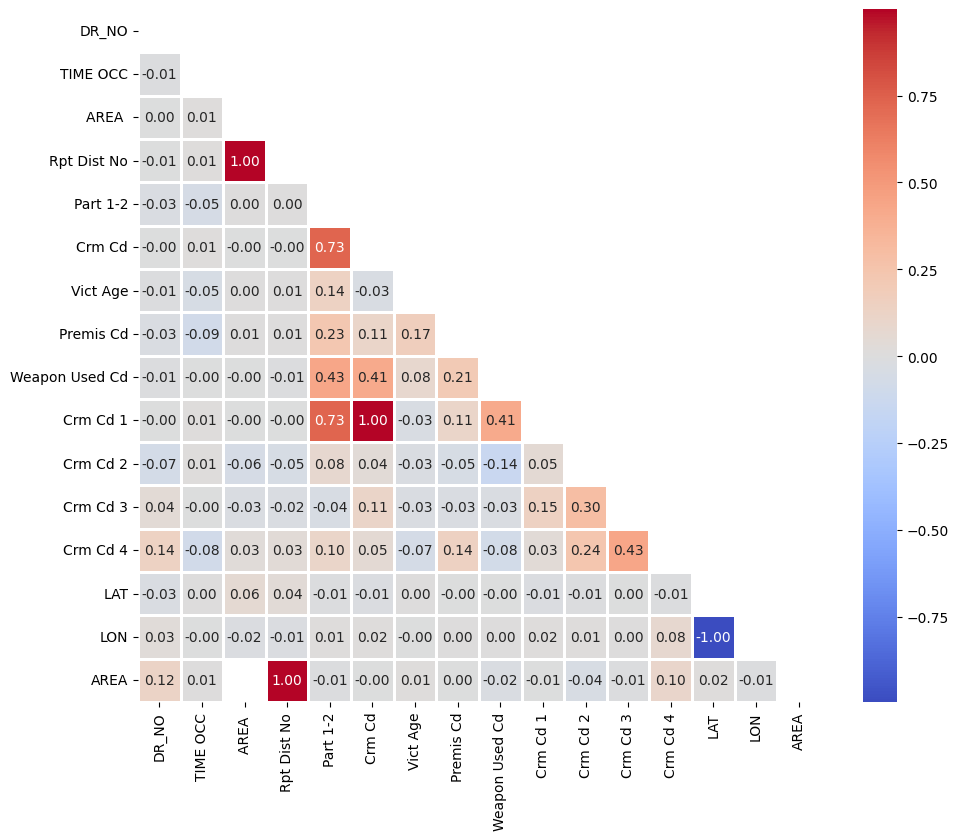

In [23]:
cd_num = cd.select_dtypes(include=np.number)

fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(cd_num.corr(), dtype=bool))

sns.heatmap(cd_num.corr(), mask=mask, cmap='coolwarm', center=0, linewidths=1, annot=True, fmt=".2f")

### Show missing data

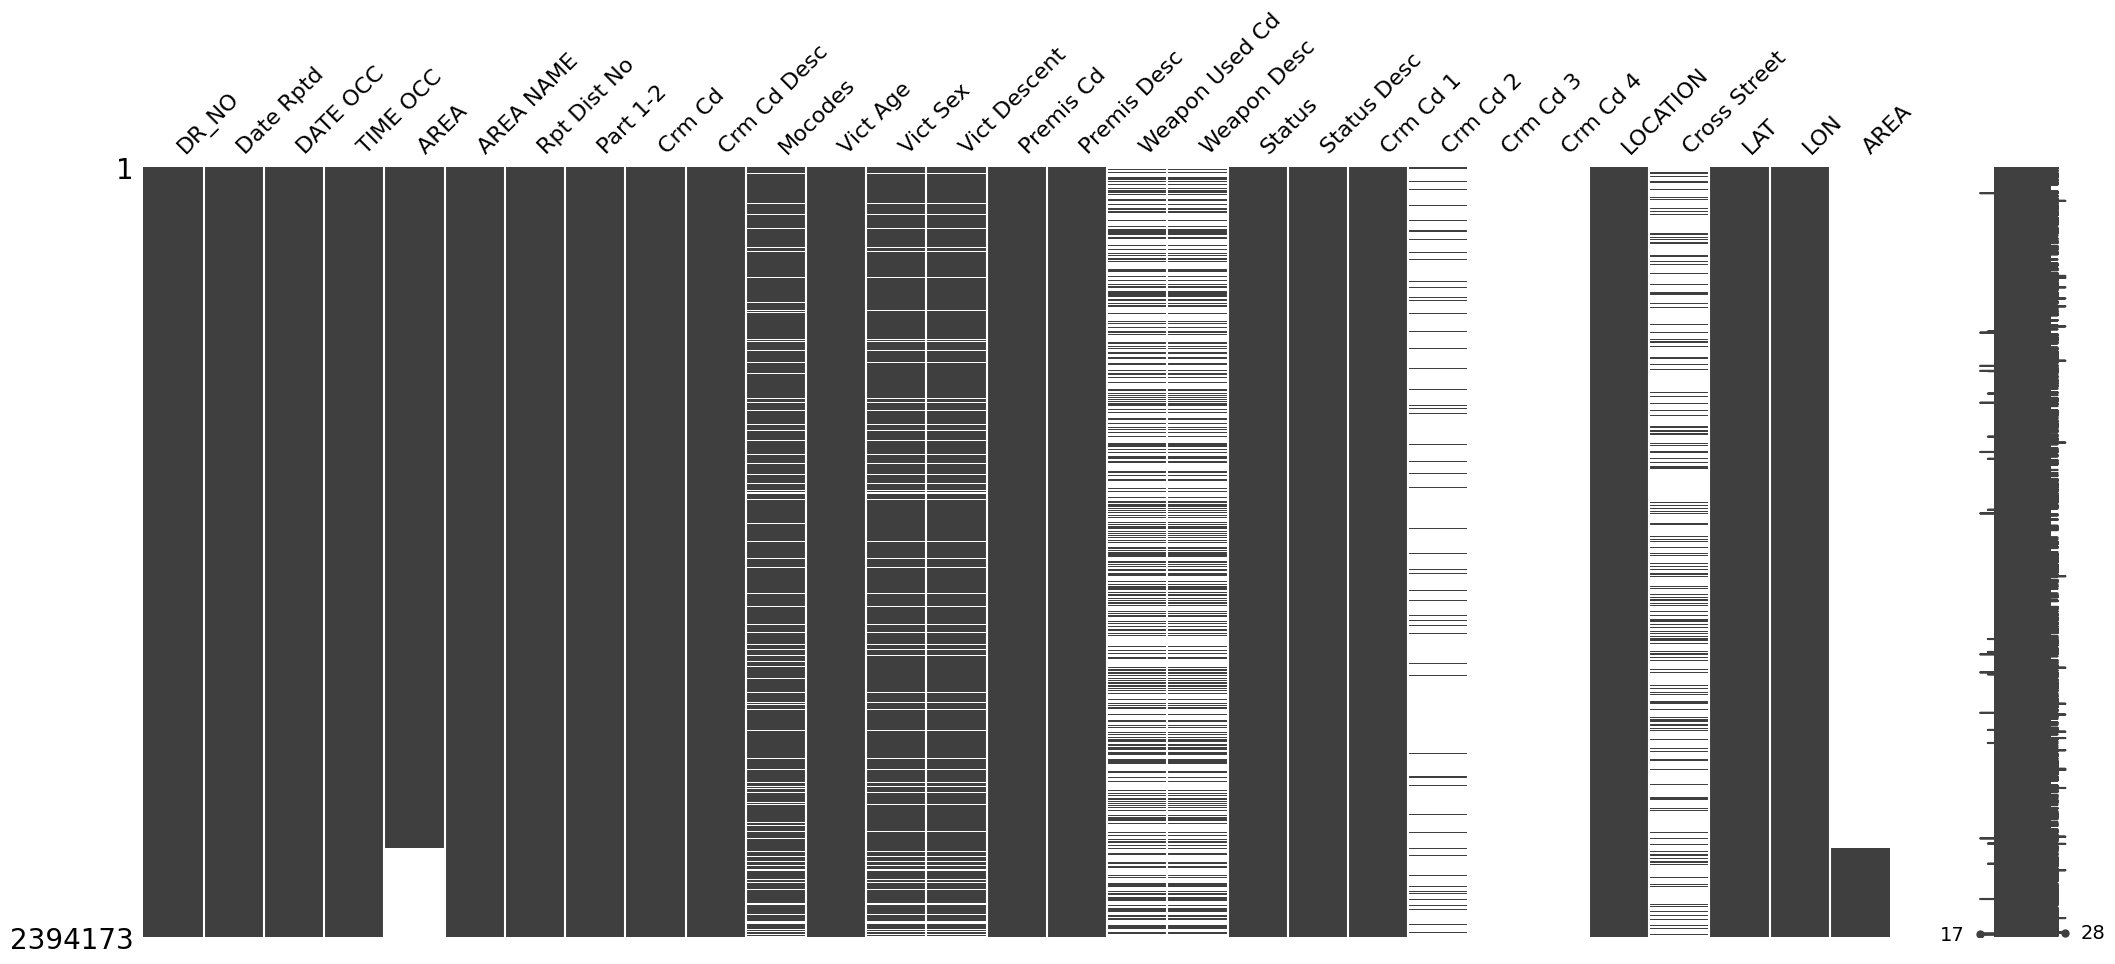

In [24]:
msno.matrix(cd)
plt.show()

We from this can justify cleaning the data a bit before resuming overall analysis

In [25]:
cd = cd.reset_index()
cd.drop(columns=['DR_NO', 'Date Rptd','Part 1-2', 'Mocodes','Status', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street', 'index'],inplace=True)
cd.drop_duplicates(keep=False,inplace=True)

### Making datetime columns more presentable

In [26]:
cd['DateTimeValues'] = pd.to_datetime(cd['DATE OCC'])
cd['year'] = cd['DateTimeValues'].dt.year
cd['month'] = cd['DateTimeValues'].dt.month
cd['day'] = cd['DateTimeValues'].dt.day

cd['TIME OCC'] = cd['TIME OCC'].astype(str).str.zfill(4)
cd['HOUR OCC'] = cd['TIME OCC'].apply(lambda t: int(t[:2]))

cd.info()

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\1288859757.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cd['DateTimeValues'] = pd.to_datetime(cd['DATE OCC'])


<class 'pandas.core.frame.DataFrame'>
Index: 2379740 entries, 0 to 2394172
Data columns (total 26 columns):
 #   Column          Dtype         
---  ------          -----         
 0   DATE OCC        object        
 1   TIME OCC        object        
 2   AREA            float64       
 3   AREA NAME       object        
 4   Rpt Dist No     int16         
 5   Crm Cd          int16         
 6   Crm Cd Desc     object        
 7   Vict Age        int8          
 8   Vict Sex        object        
 9   Vict Descent    object        
 10  Premis Cd       float32       
 11  Premis Desc     object        
 12  Weapon Used Cd  float32       
 13  Weapon Desc     object        
 14  Status Desc     object        
 15  Crm Cd 1        float32       
 16  Crm Cd 2        float32       
 17  LOCATION        object        
 18  LAT             float32       
 19  LON             float32       
 20  AREA            float64       
 21  DateTimeValues  datetime64[ns]
 22  year            int32  

### NUMBER OF CRIMES PER AREA

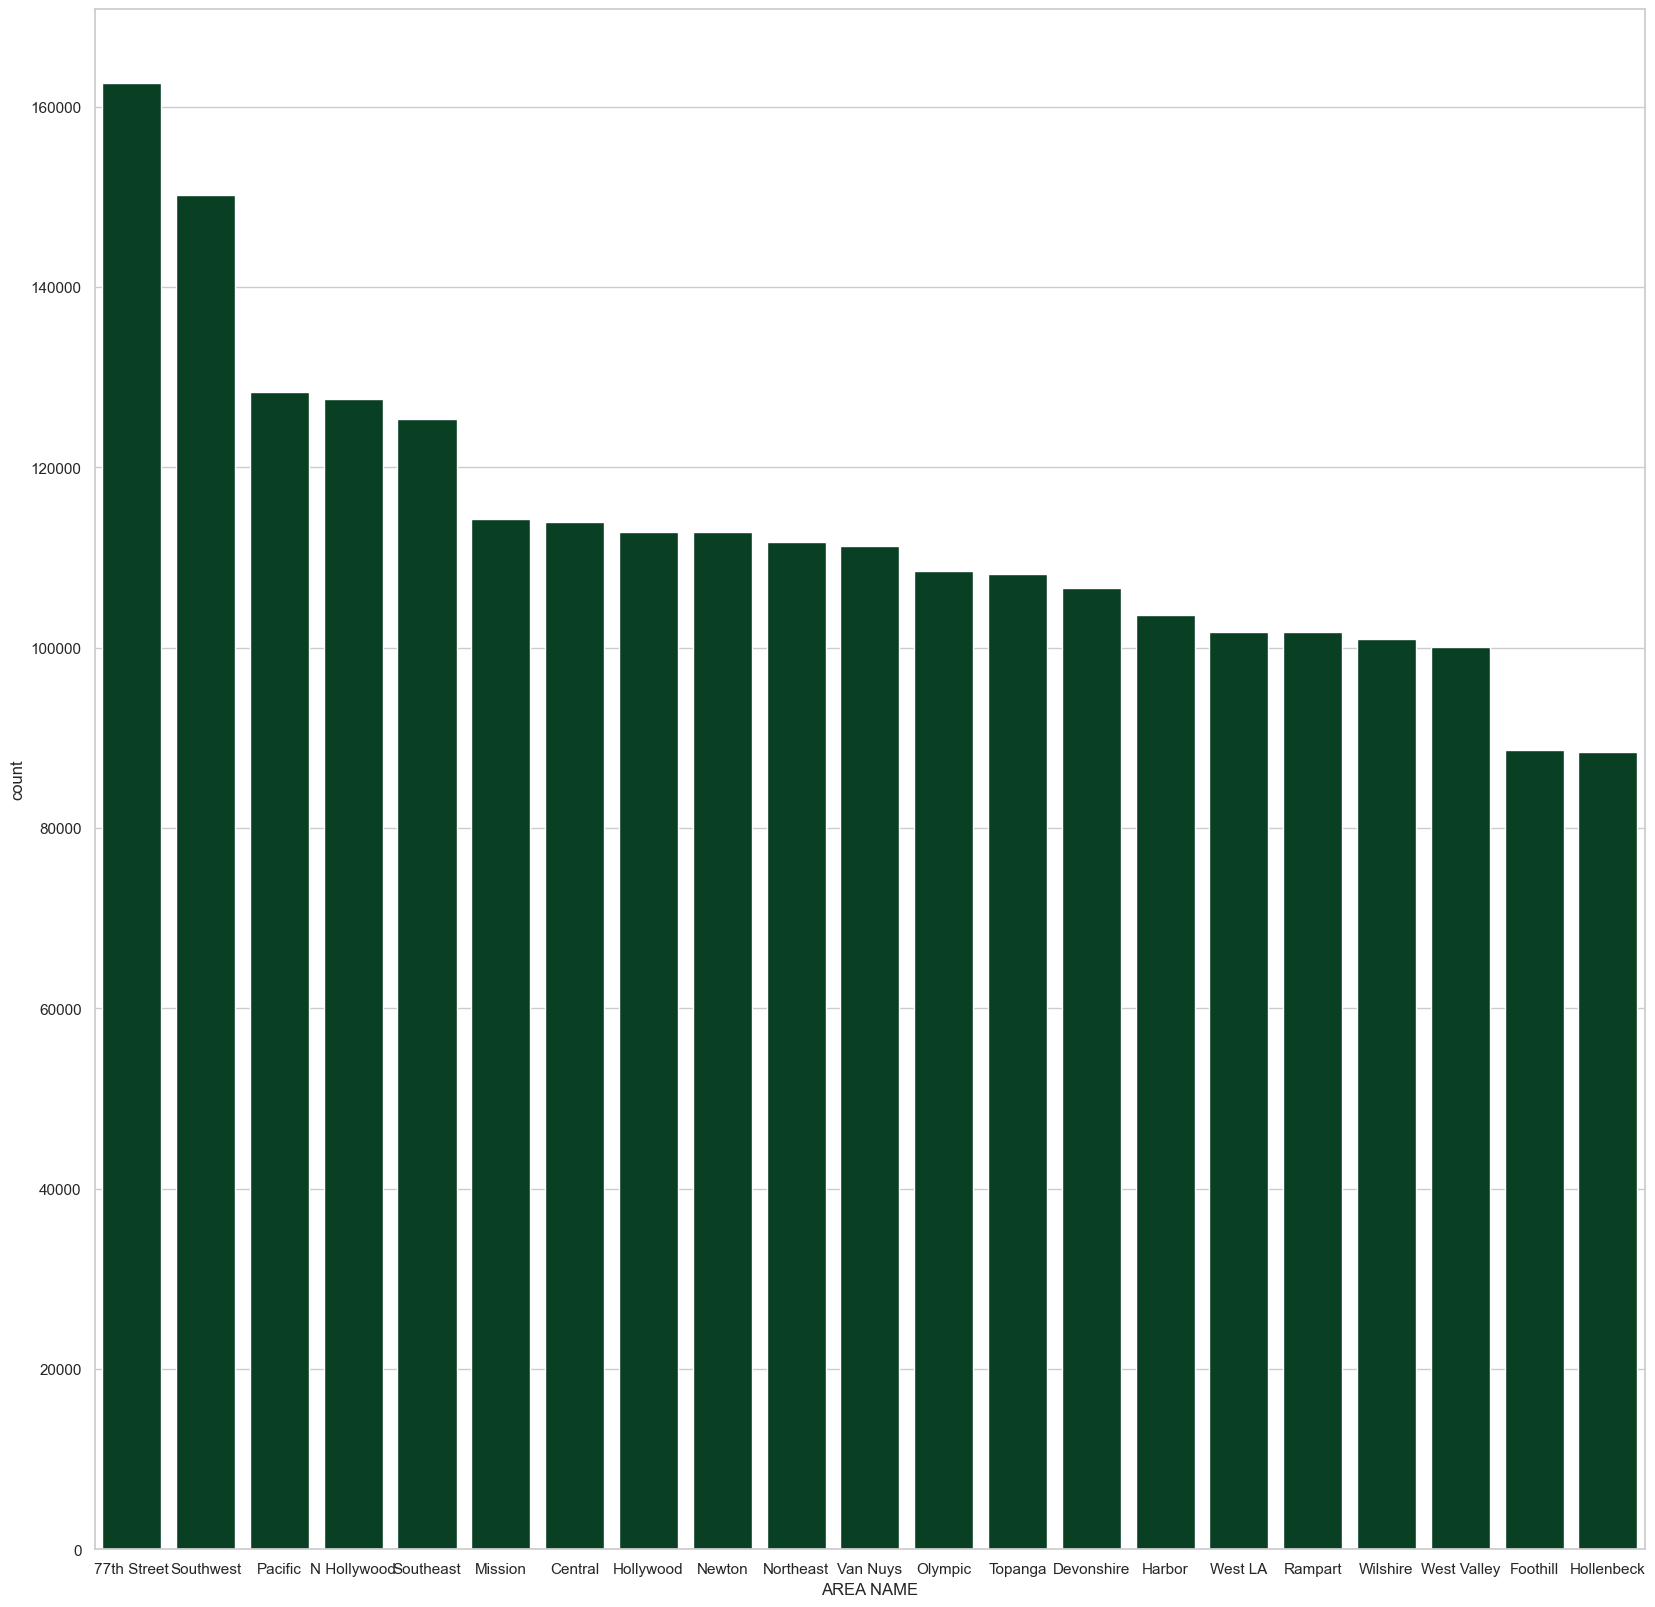

In [32]:
plt.figure(figsize=(20, 20))
sns.countplot(x="AREA NAME", data=cd, order=cd['AREA NAME'].value_counts().index)
plt.show()

### CRIME DESCRIPTIONS PER AREA

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


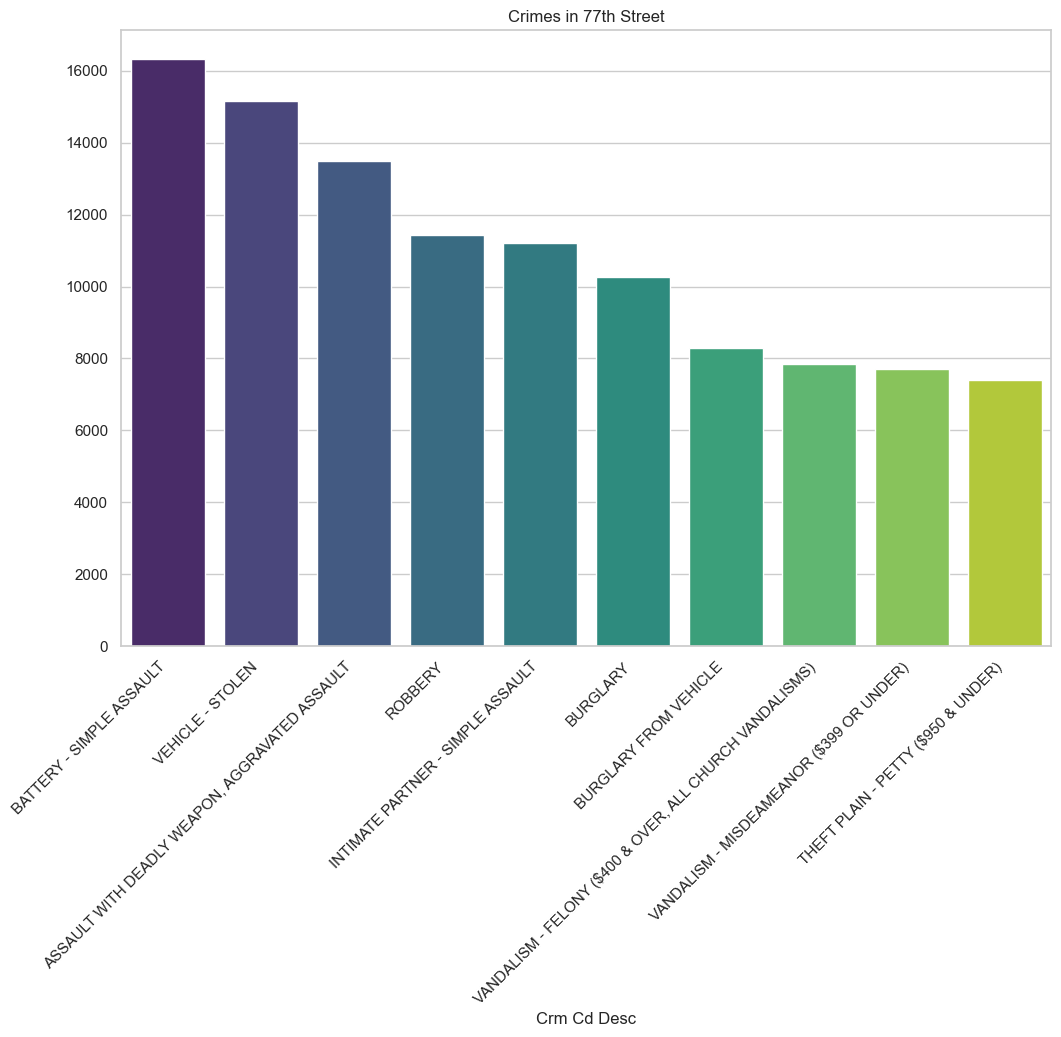

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


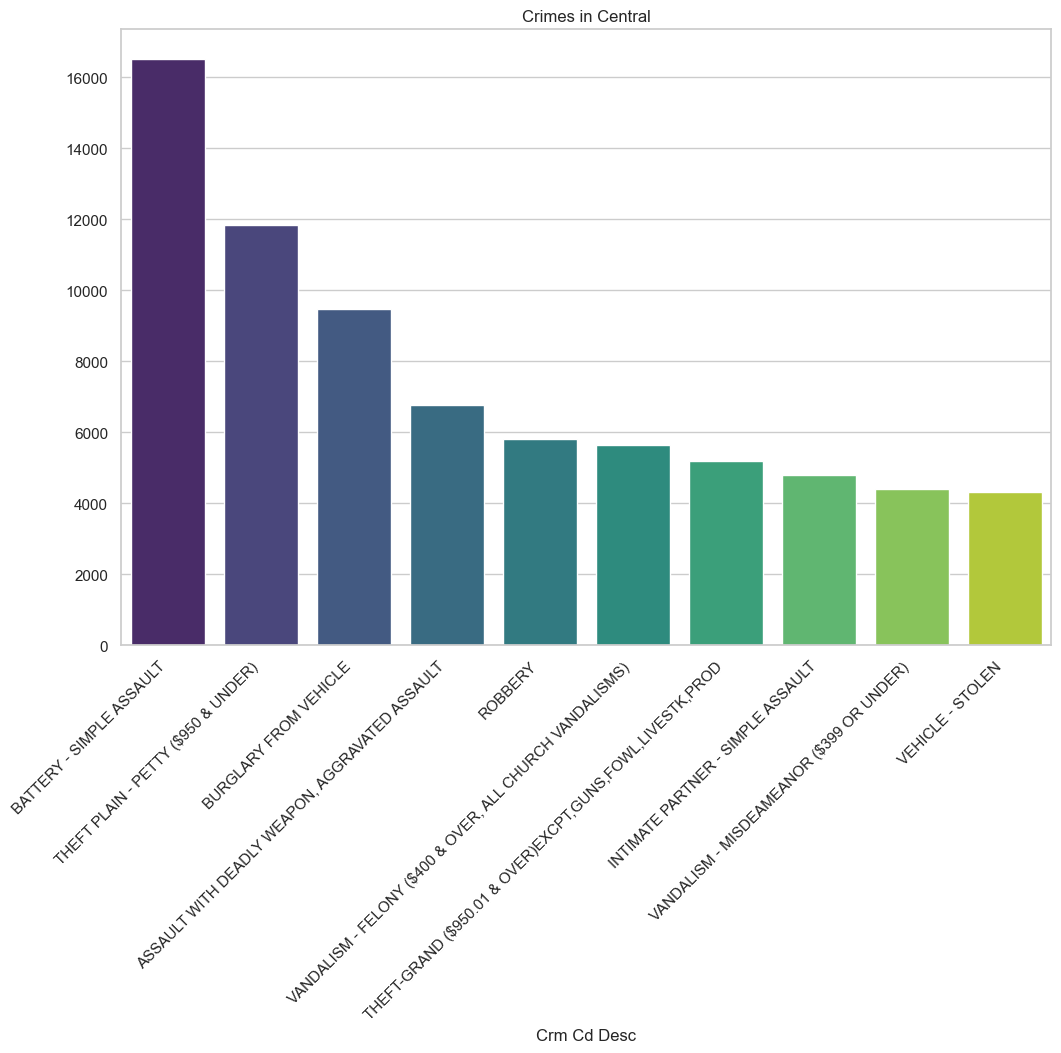

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


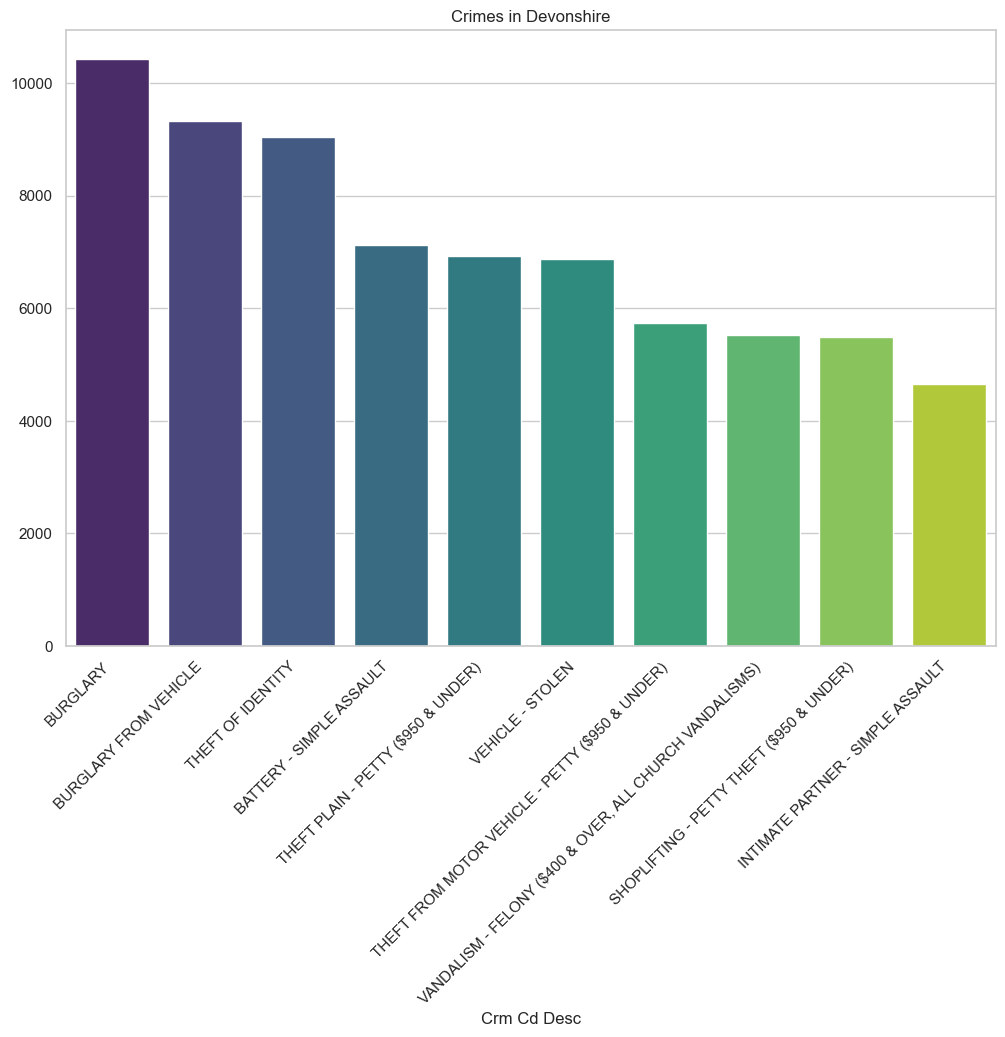

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


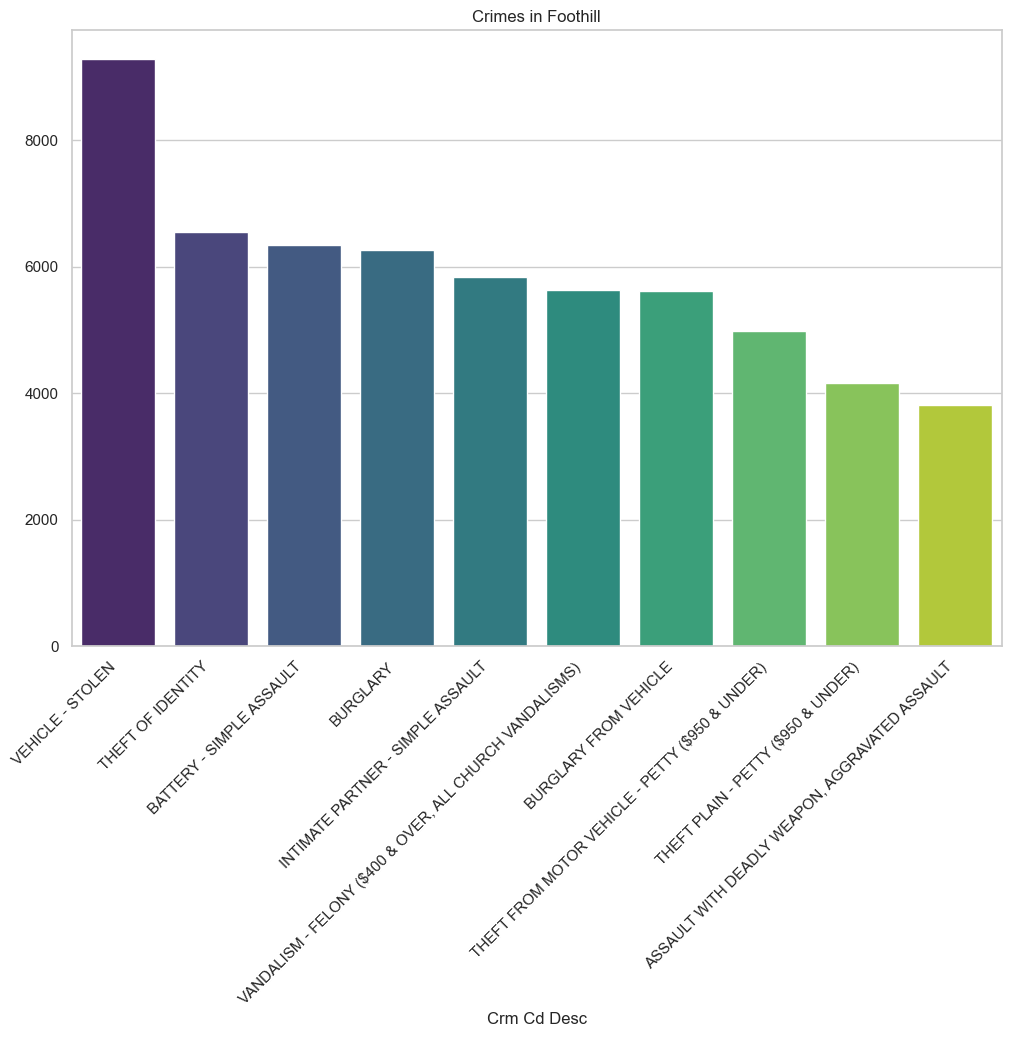

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


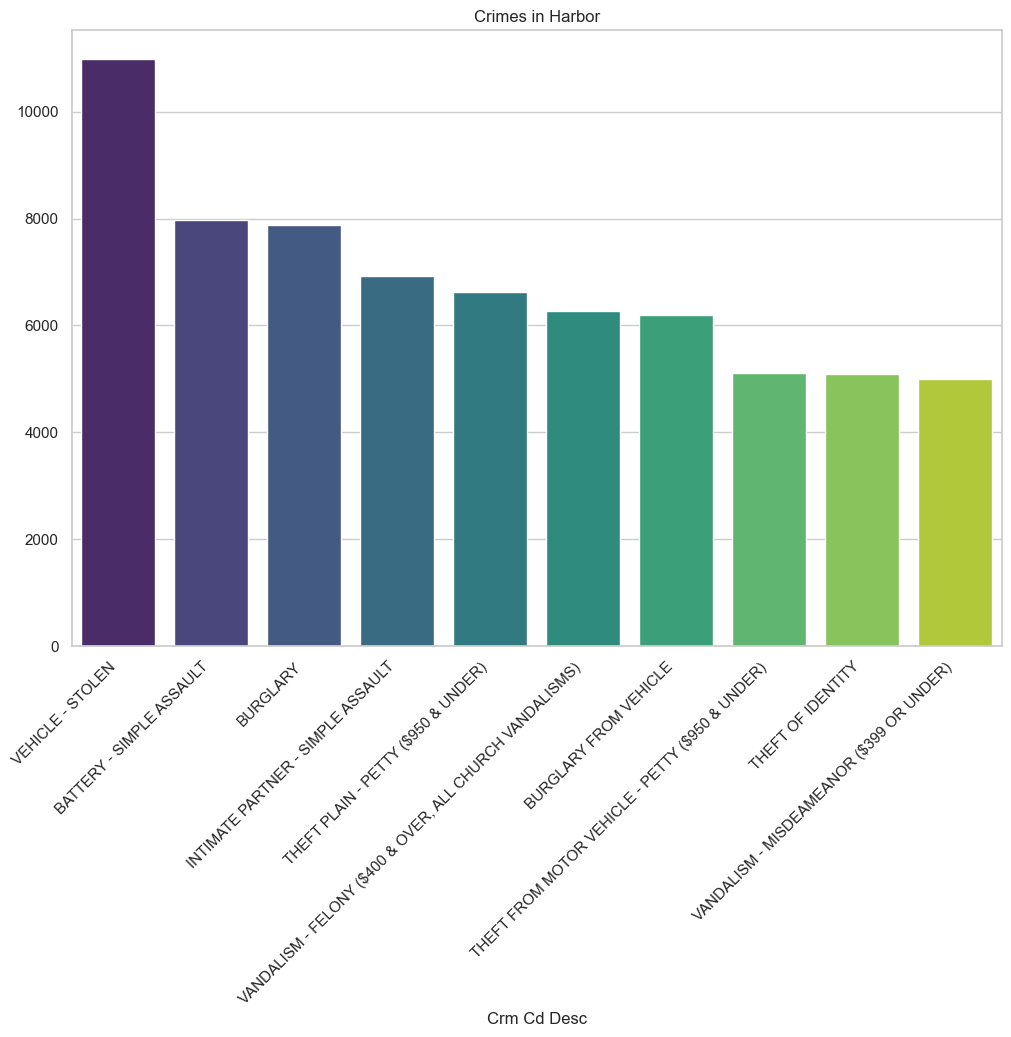

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


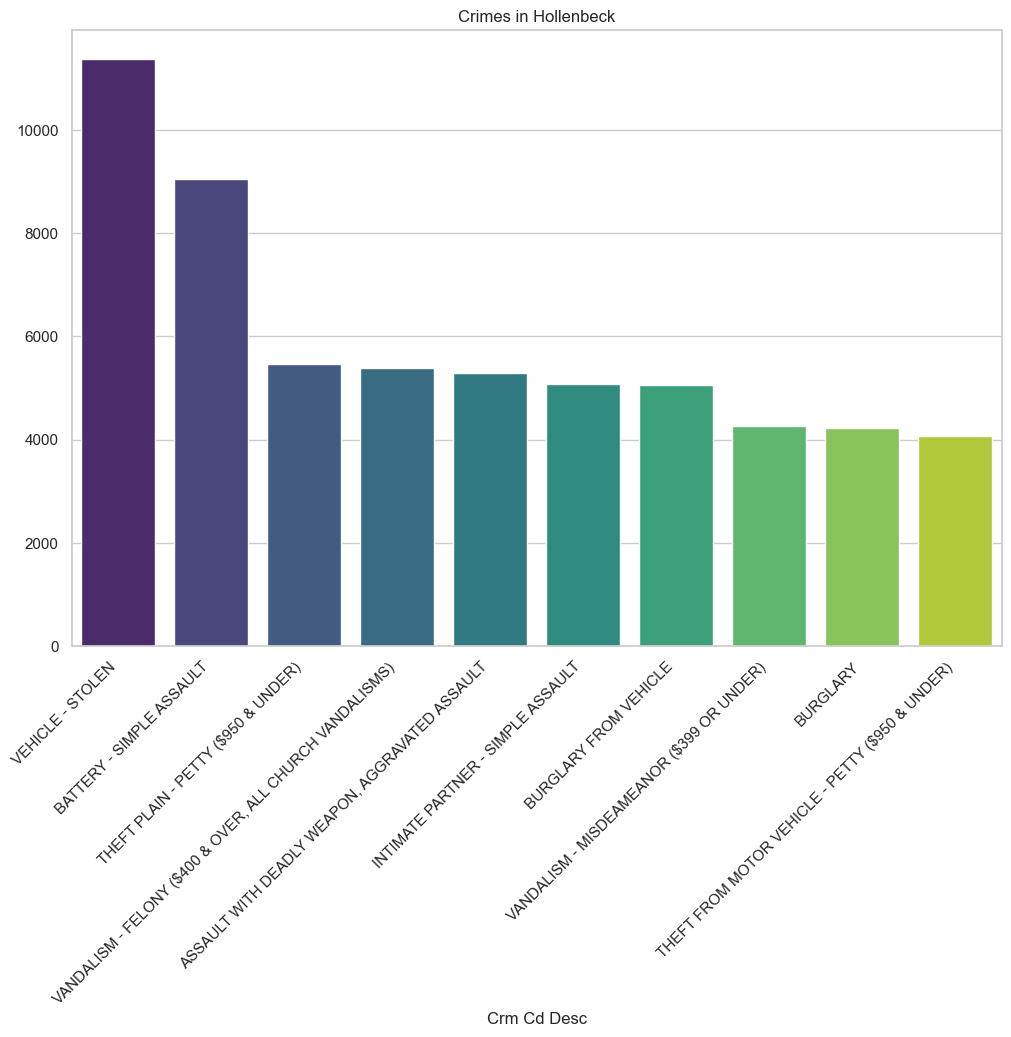

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


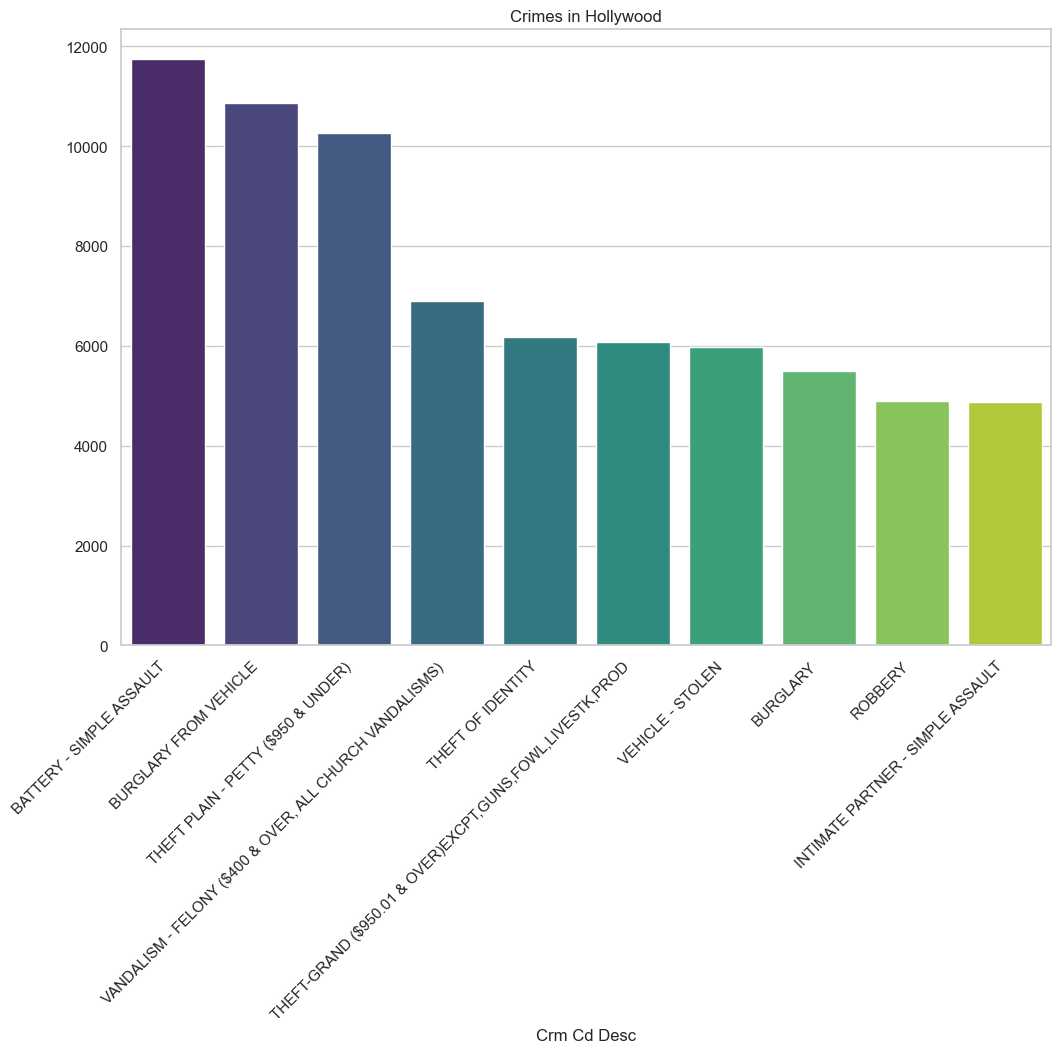

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


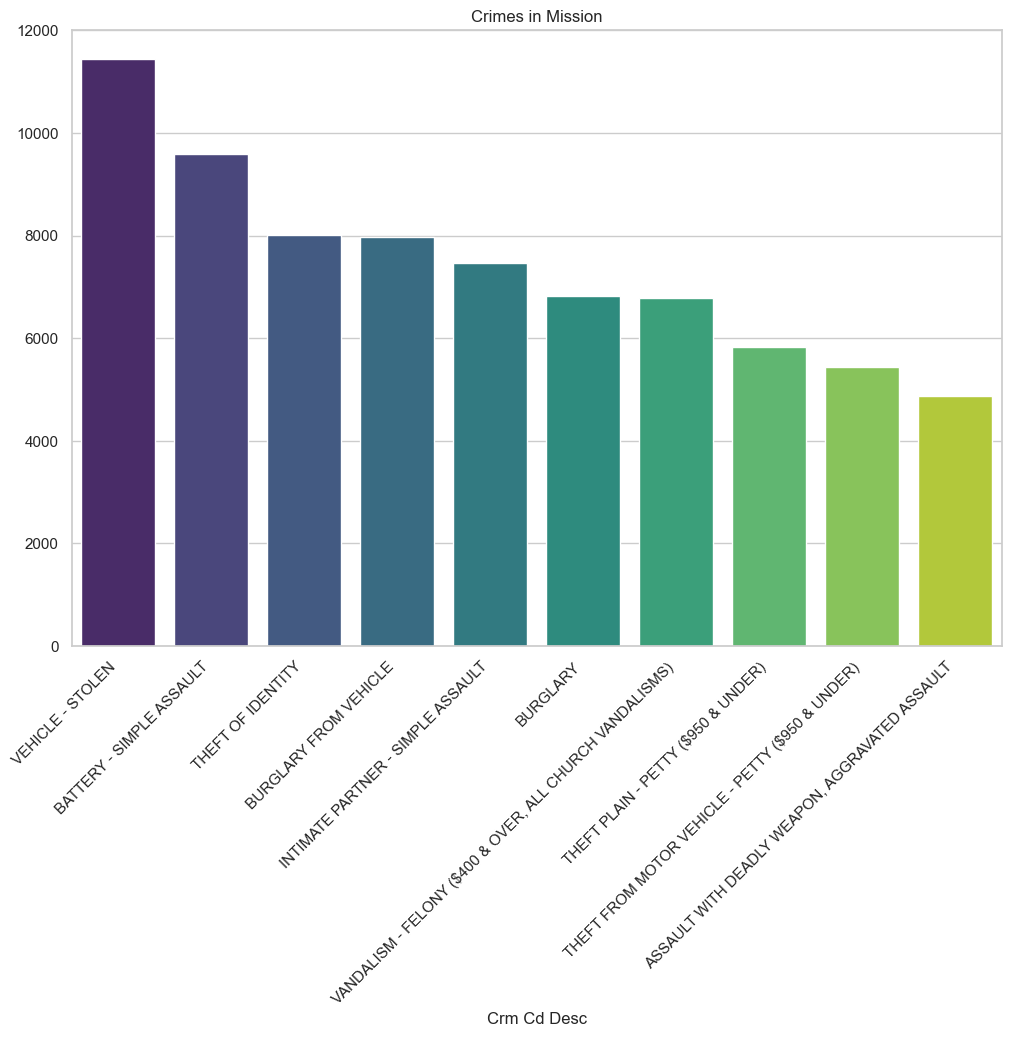

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


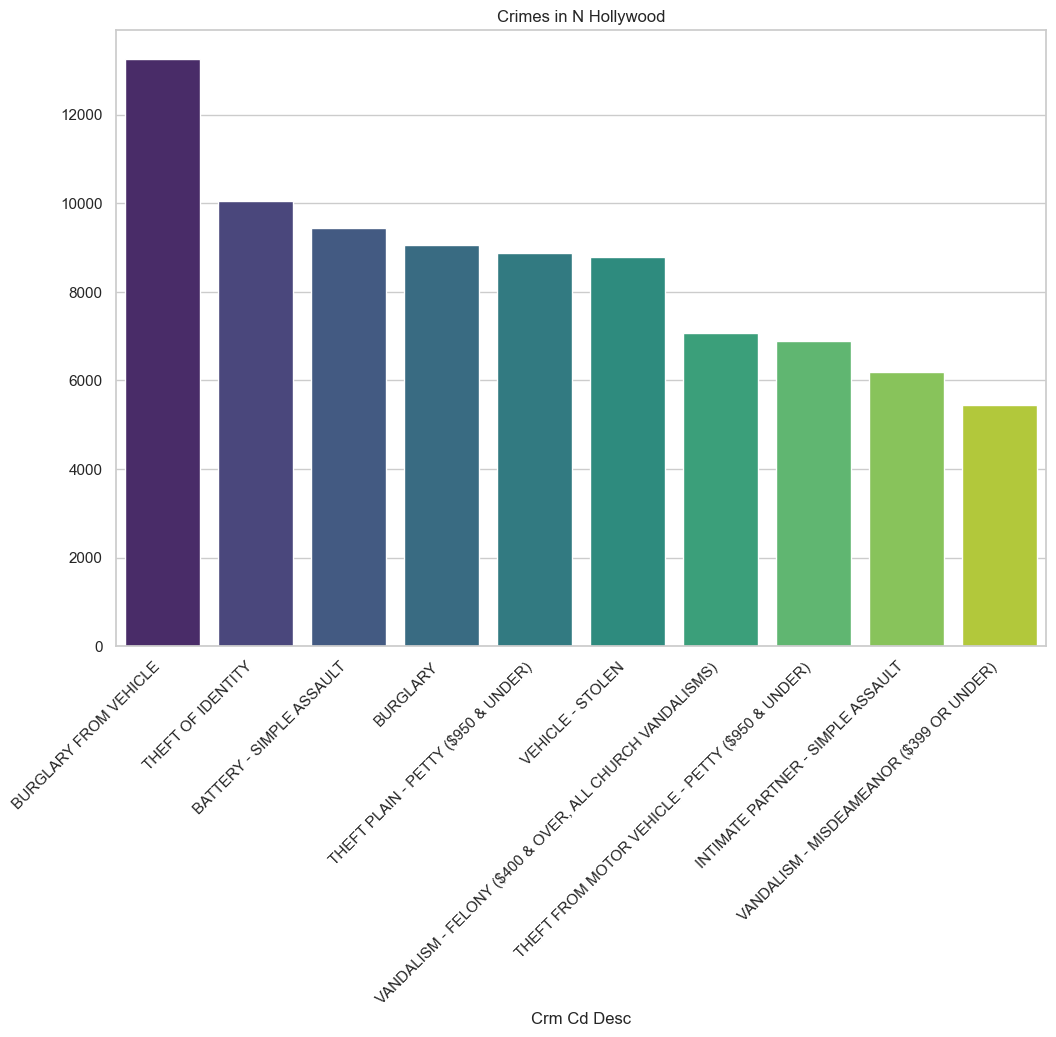

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


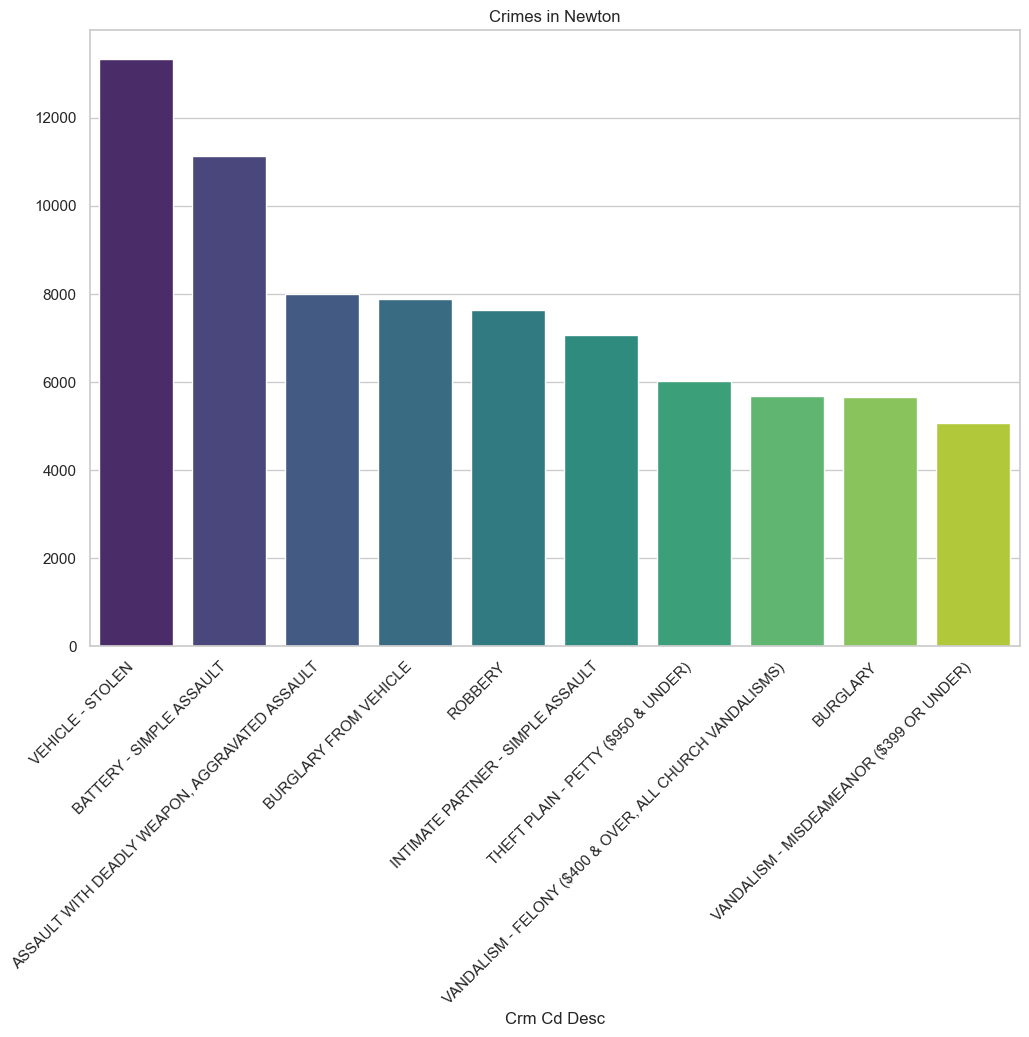

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


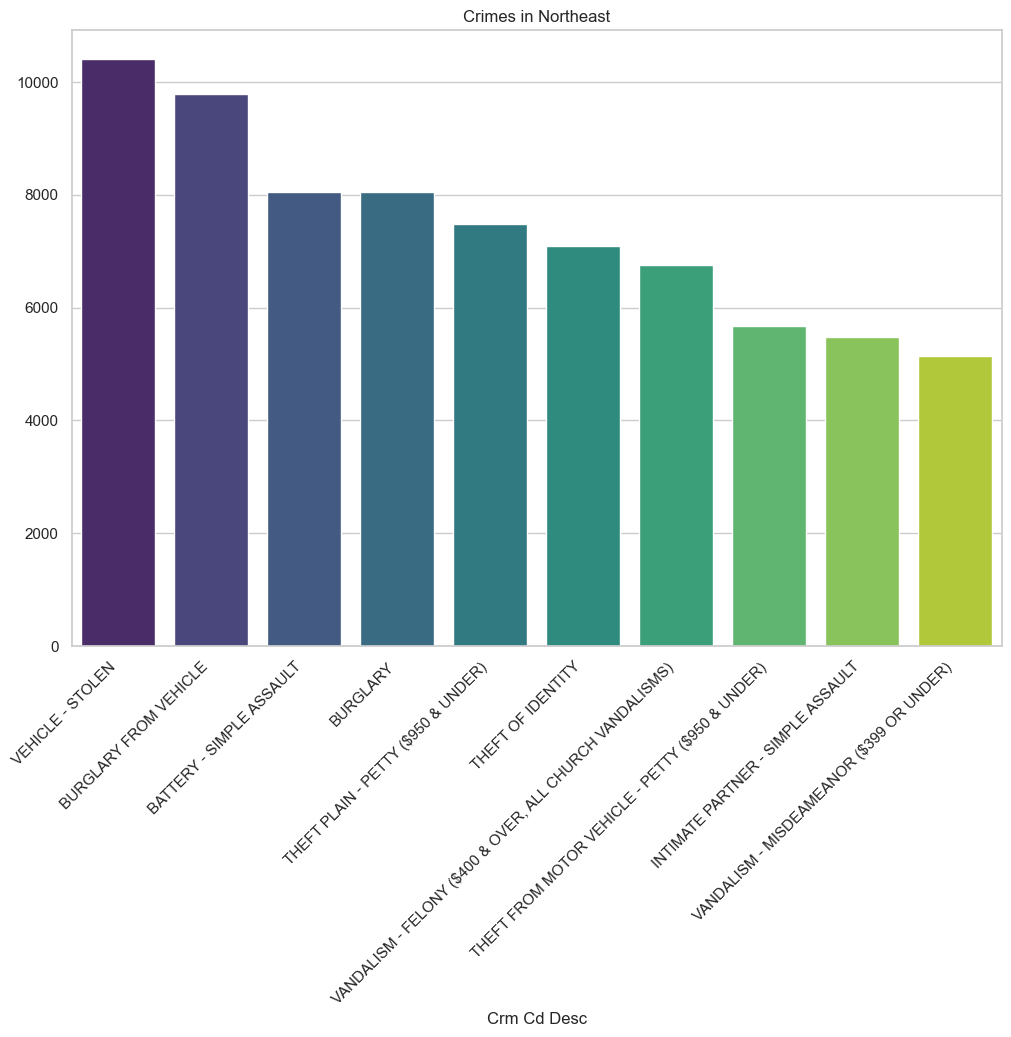

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


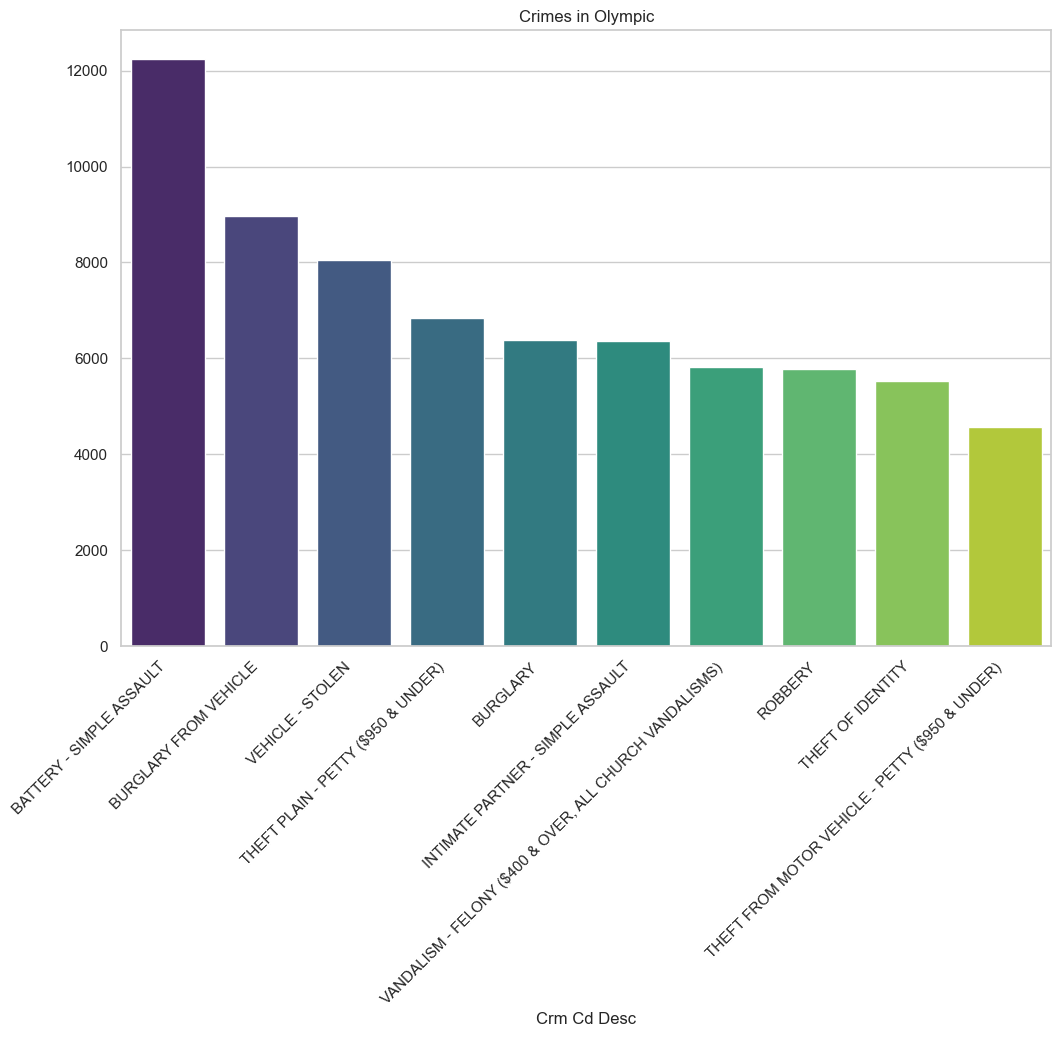

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


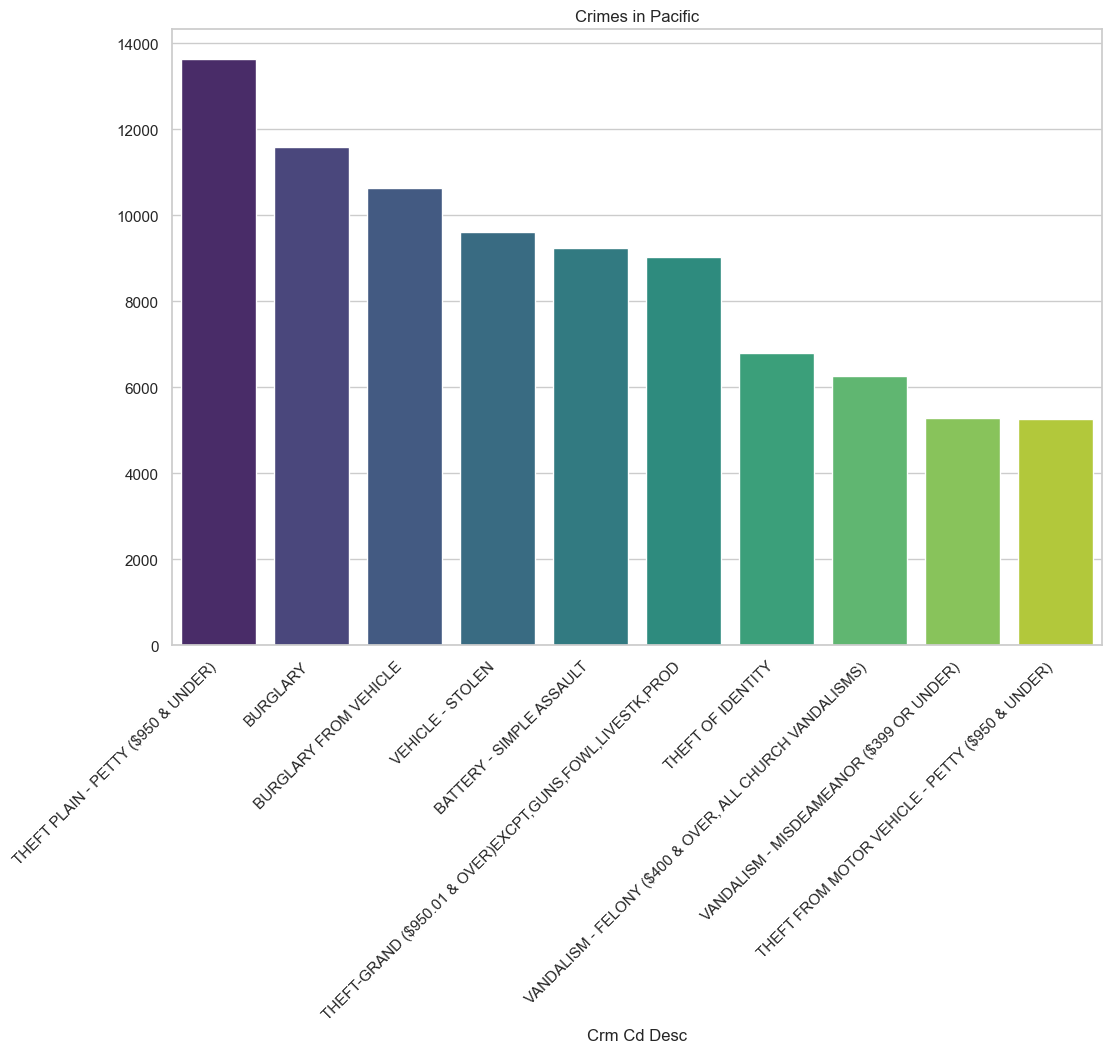

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


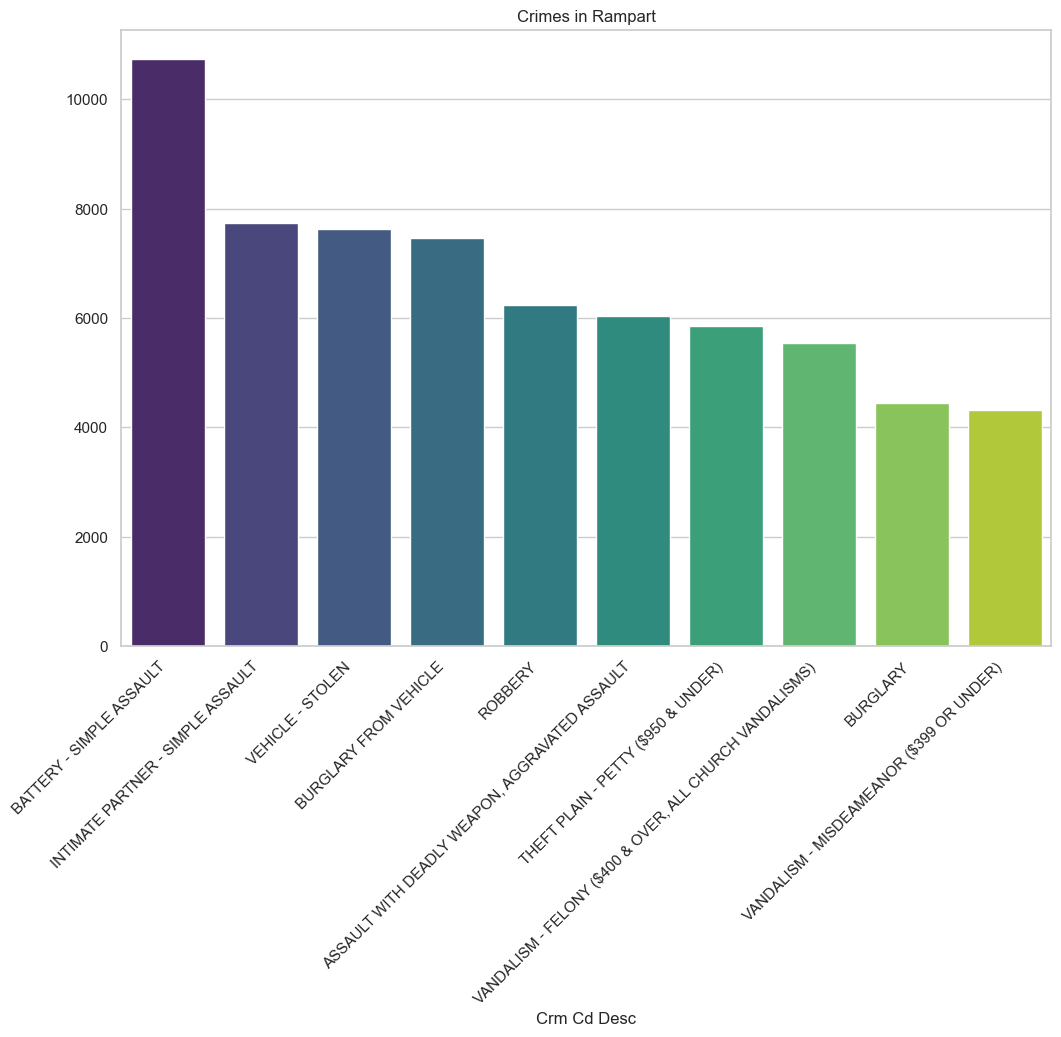

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


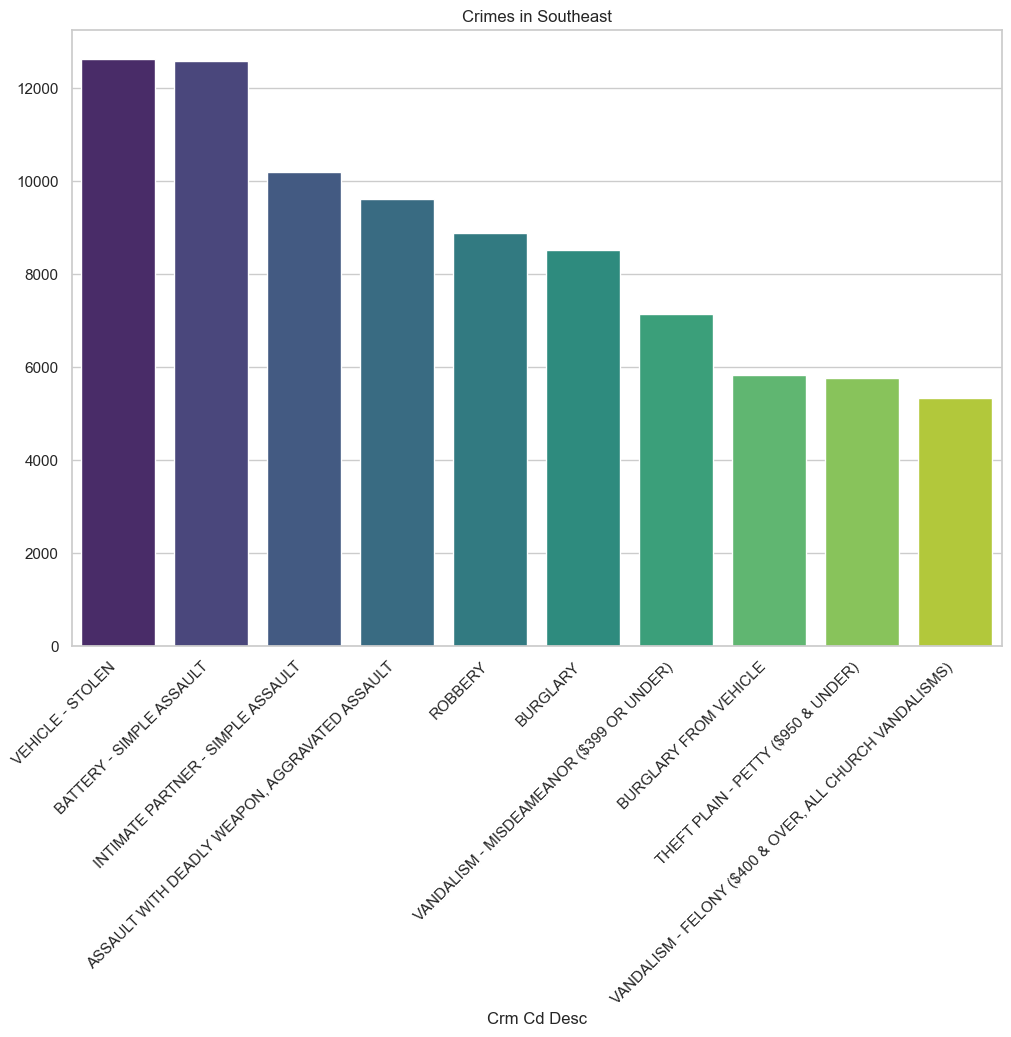

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


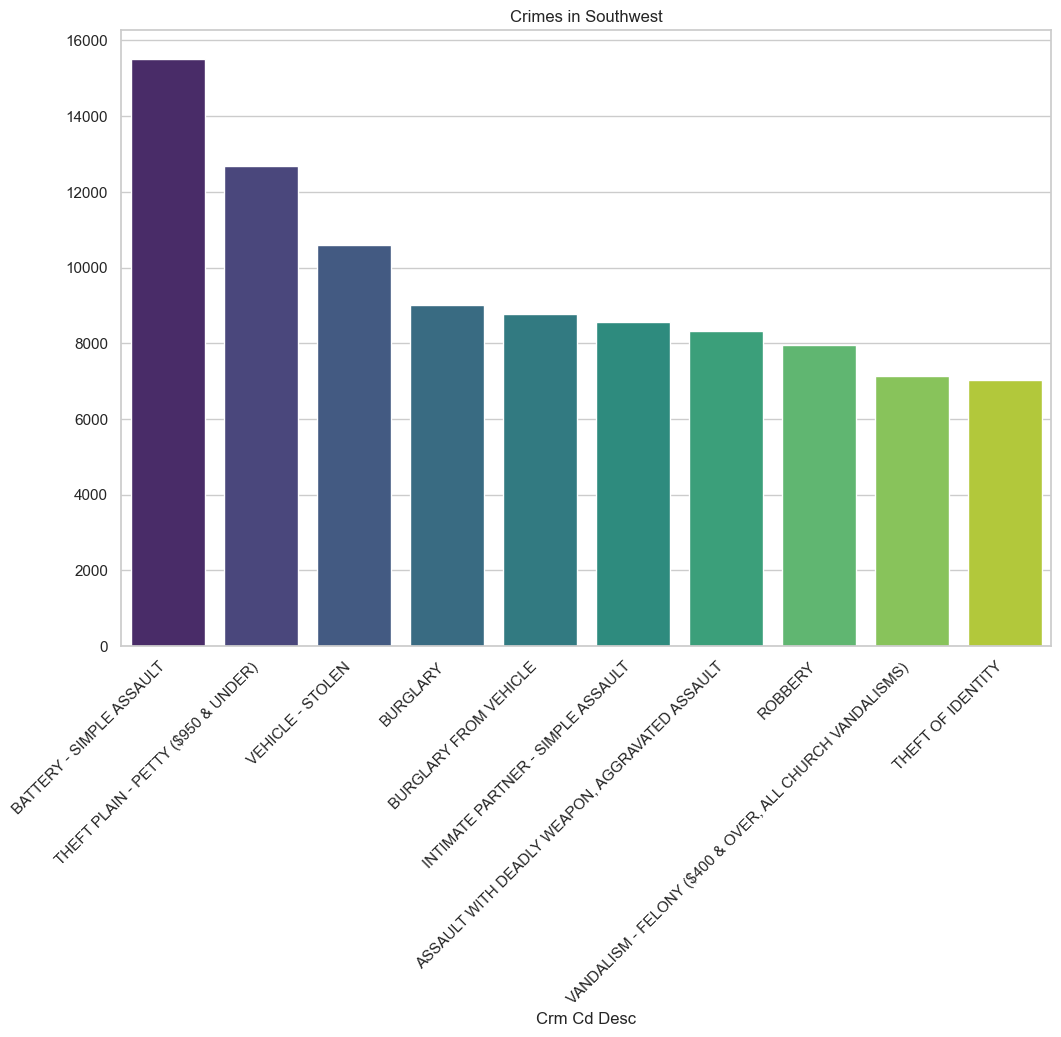

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


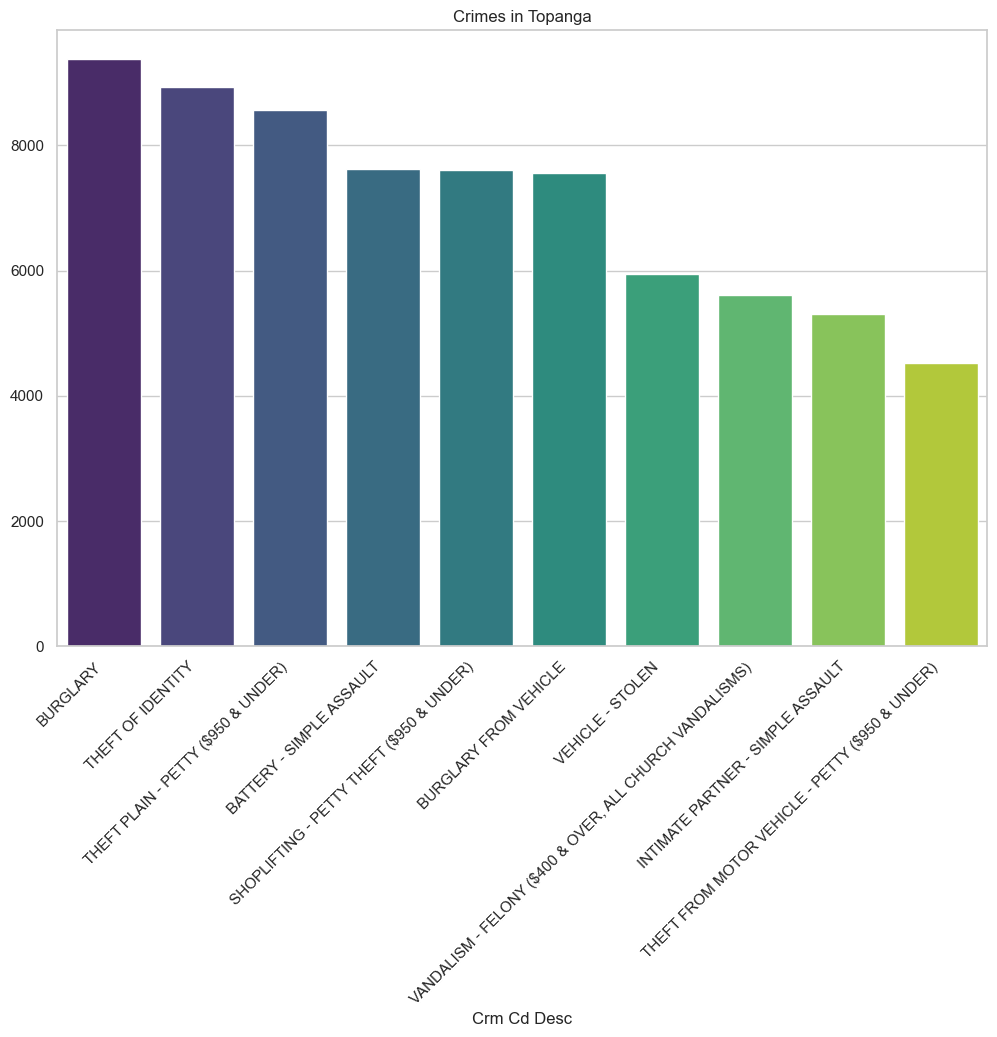

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


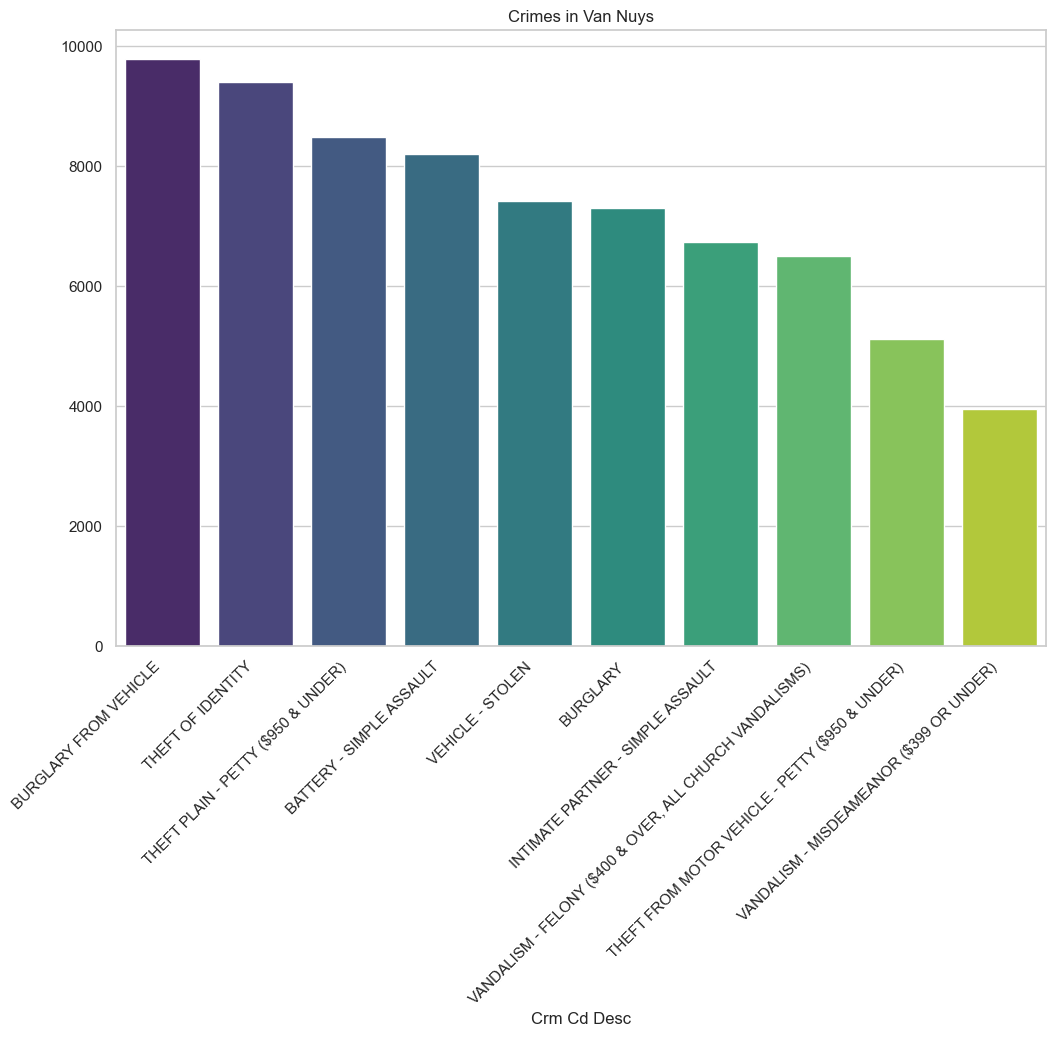

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


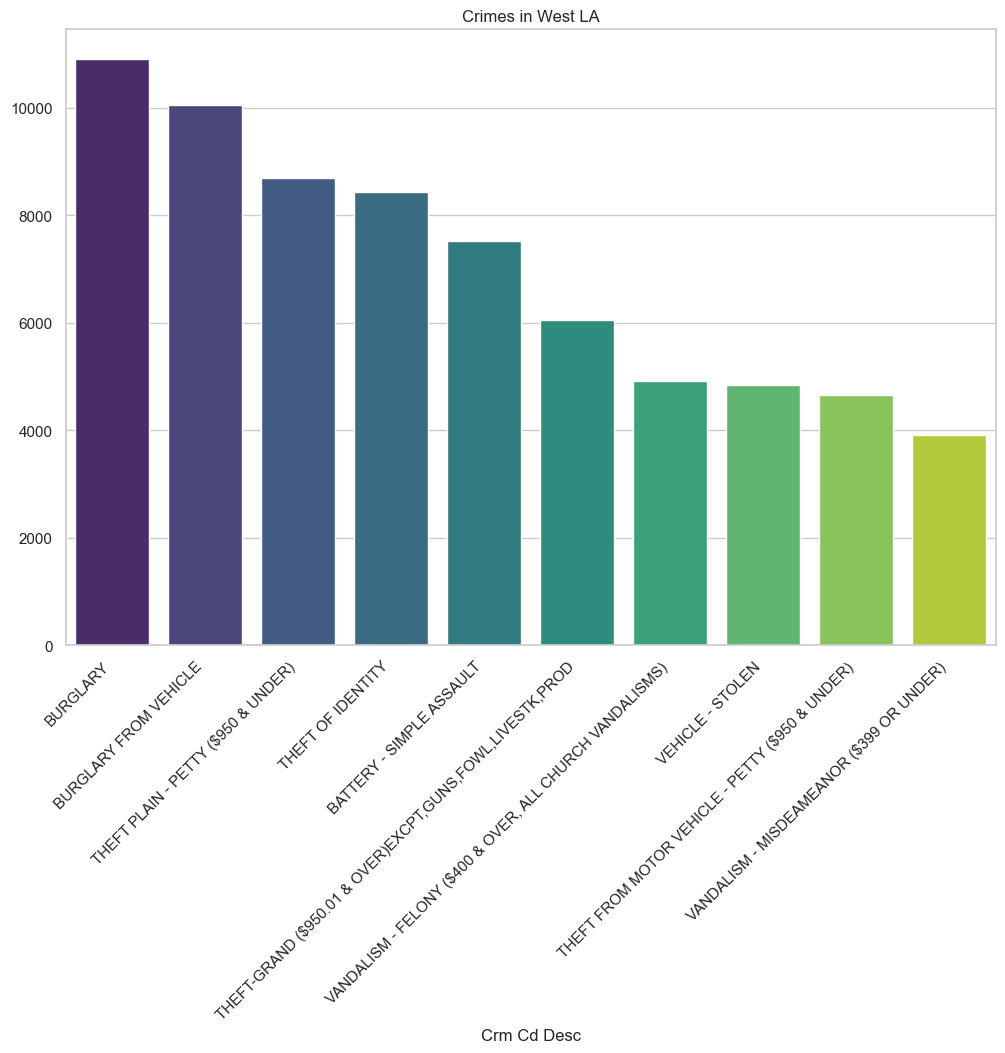

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


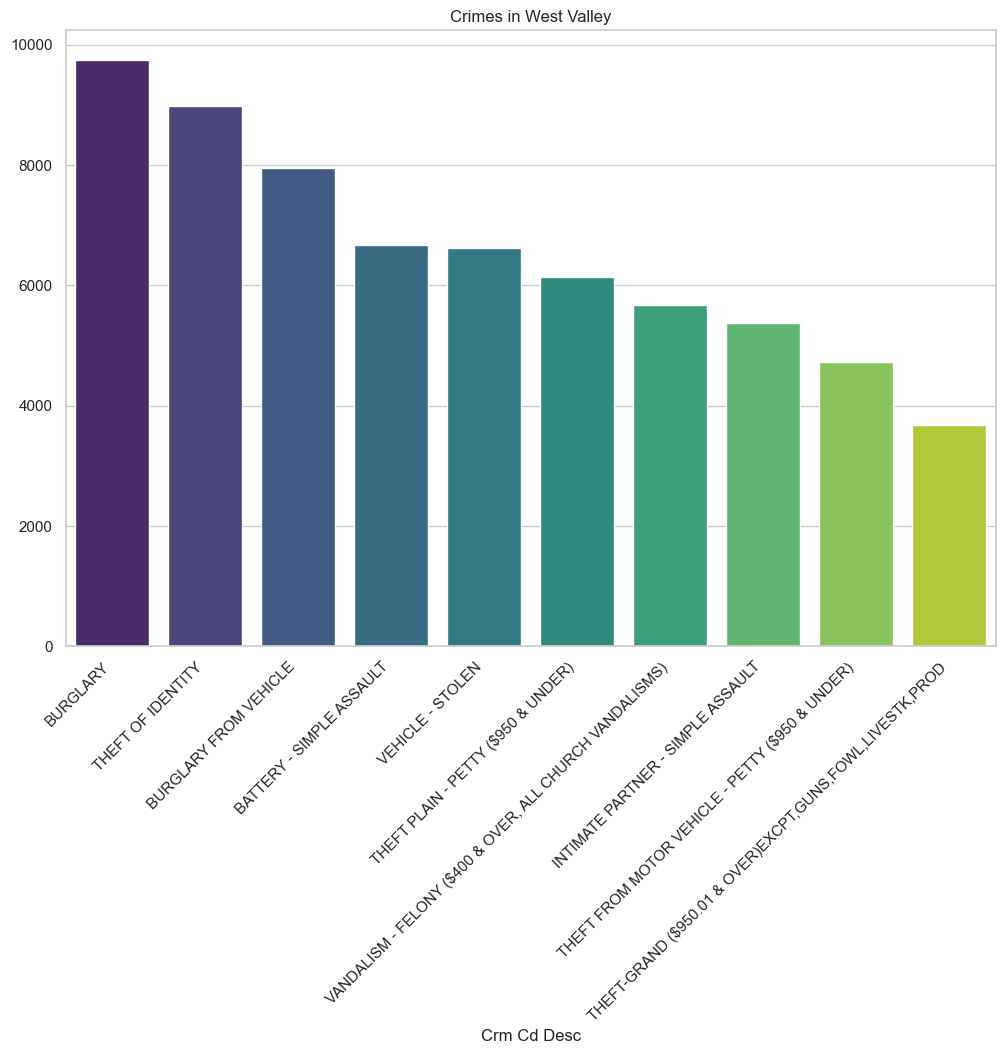

C:\Users\afons\AppData\Local\Temp\ipykernel_22892\3197136559.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")


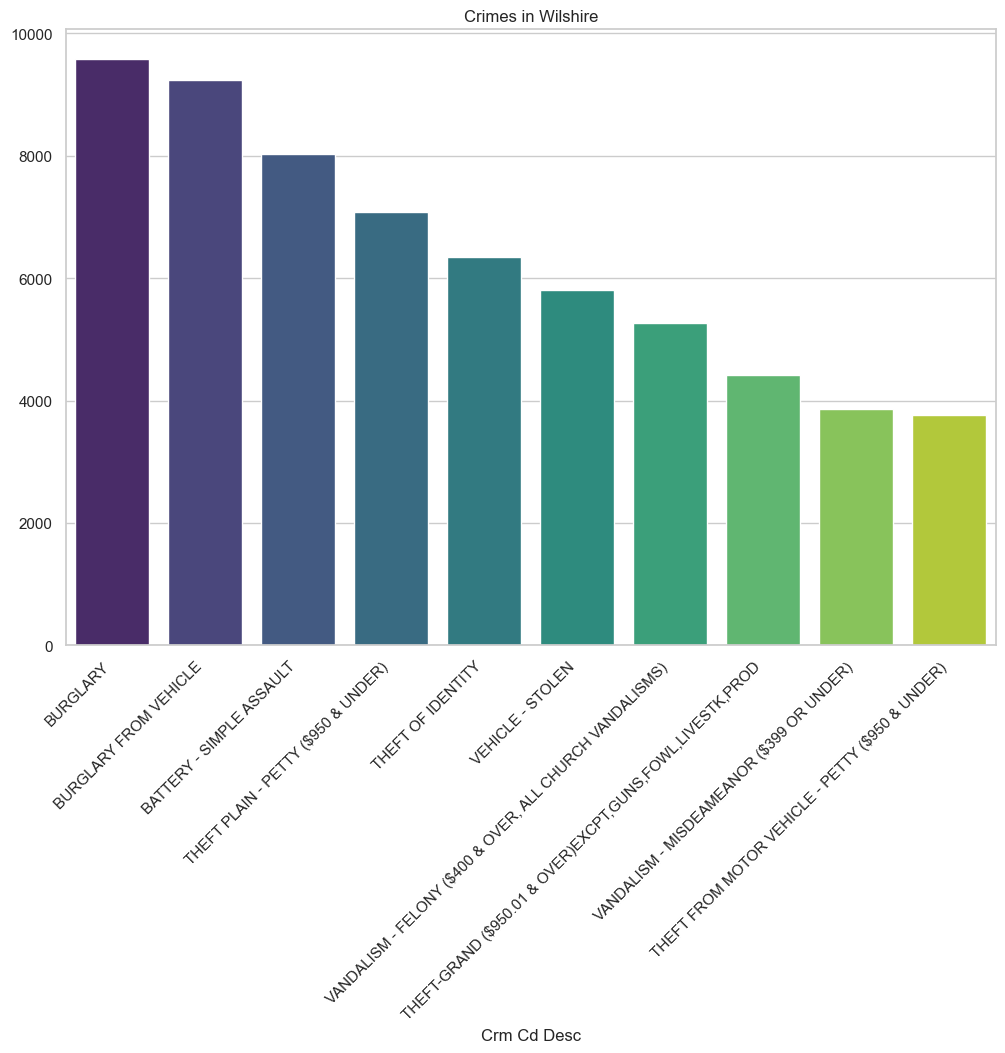

In [33]:
crimeByArea = cd['AREA NAME'].value_counts().sort_index()
crimeCommonType = {}

for area in crimeByArea.index:
    crimeArea = cd[cd['AREA NAME'] == area]['Crm Cd Desc'].value_counts().nlargest(10)
    
    for crType in crimeArea.index:
        if crType not in crimeCommonType:
            crimeCommonType[crType] = [area]
        else:
            crimeCommonType[crType].append(area)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=crimeArea.index, y=crimeArea.values, palette="viridis")
    plt.title("Crimes in " + area)
    plt.xticks(rotation=45, ha='right')
    plt.show()

### WHICH DAY OF THE MONTH DO THE MOST AMOUNT OF CRIMES OCCUR?

<Axes: xlabel='day', ylabel='count'>

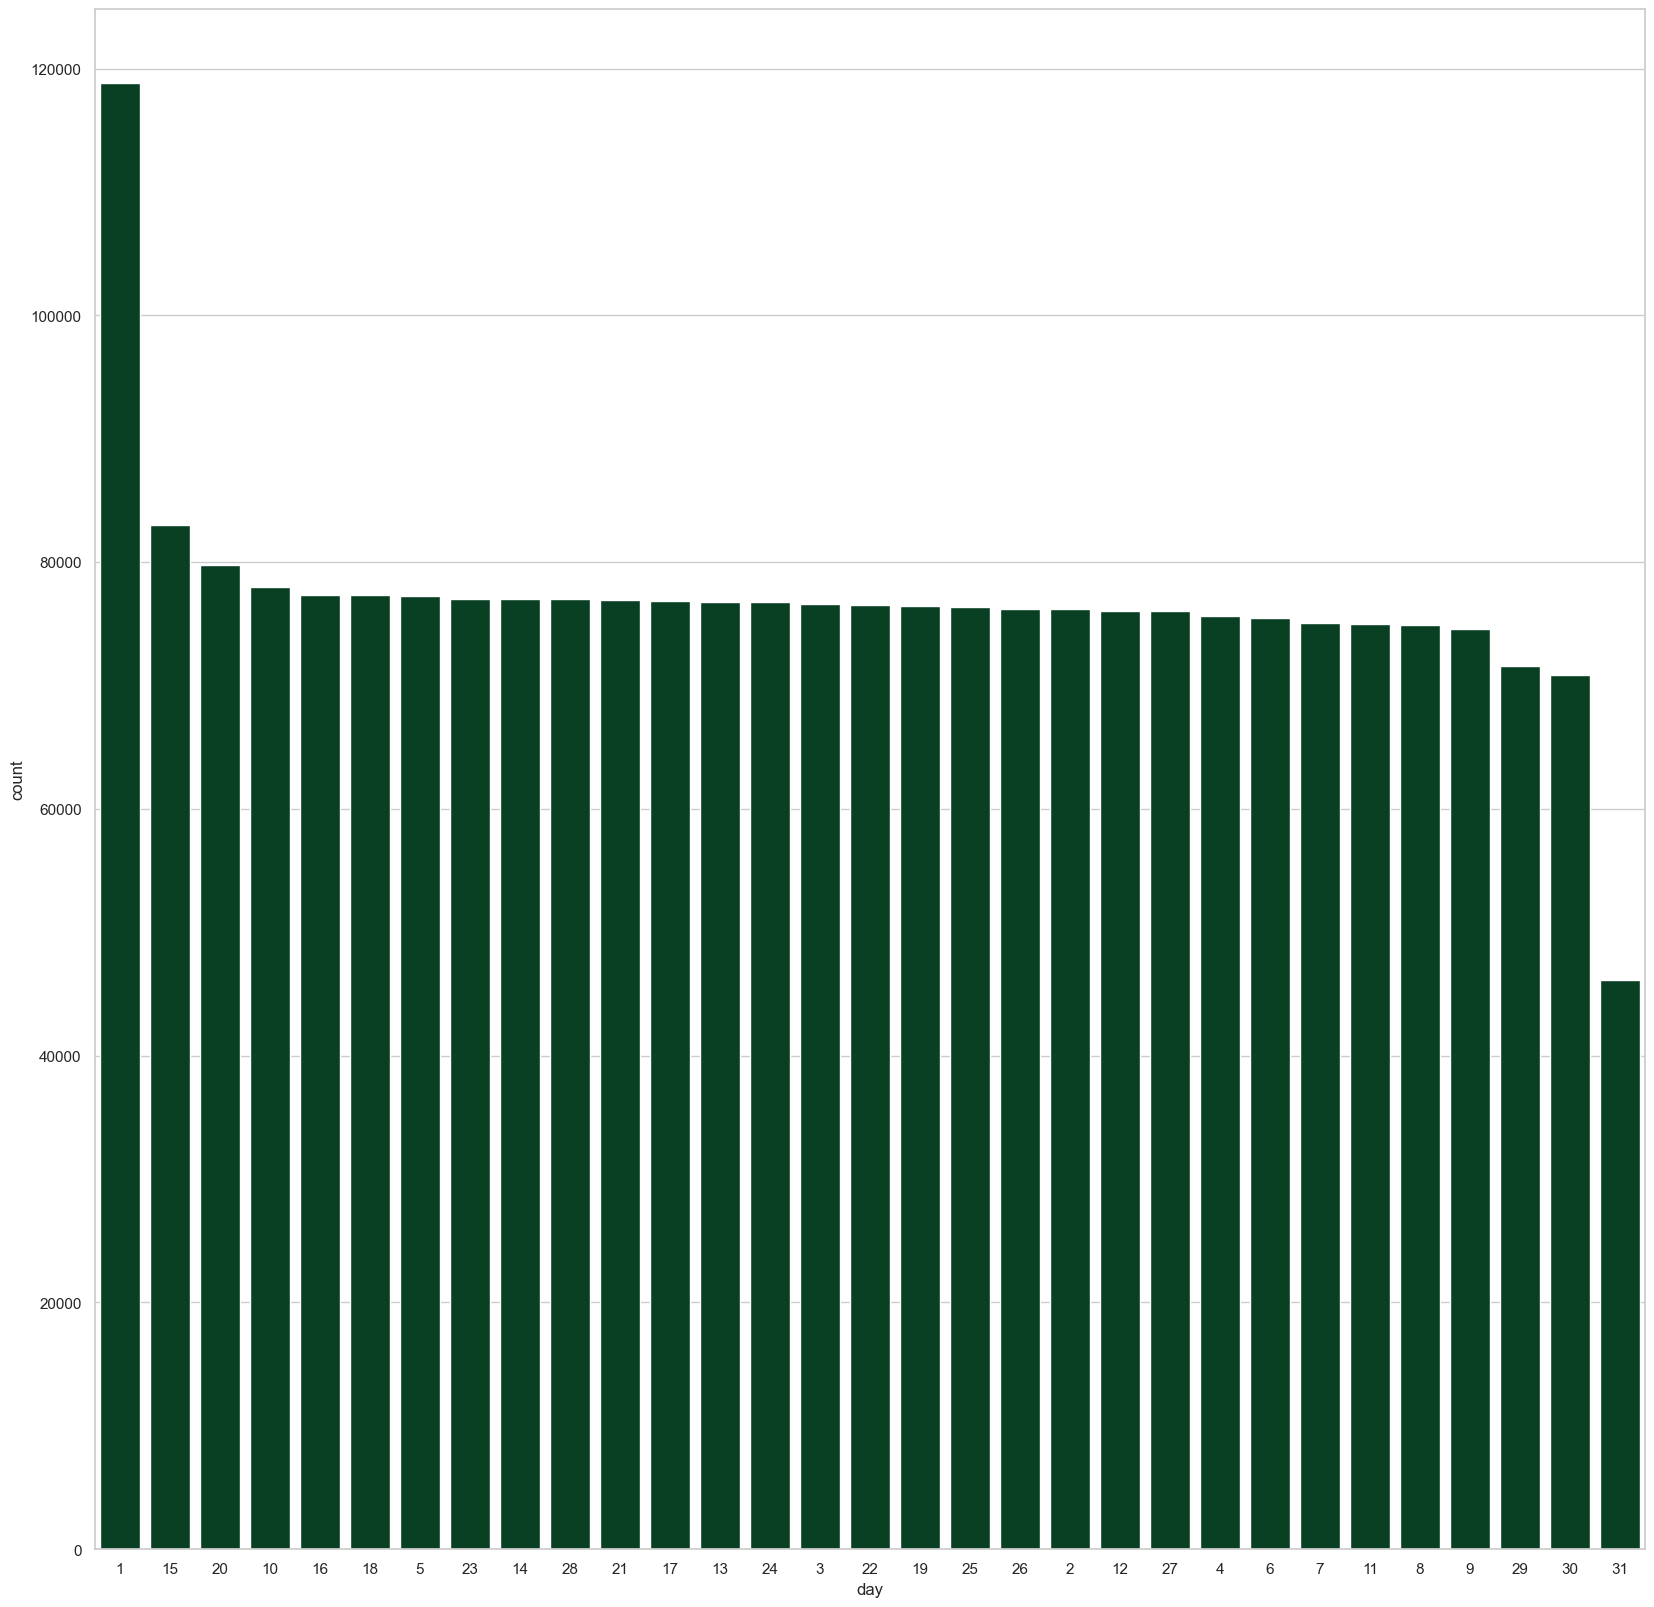

In [35]:
plt.figure(figsize=(20, 20))
sns.countplot(data=cd, x='day', order=cd['day'].value_counts().index)

The data shows that more often than not, a crime is most likely to occur in the 1st day of the month

### WHICH MONTH DID THE MOST AMOUNT OF CRIMES OCCUR?

<Axes: xlabel='month_desc', ylabel='count'>

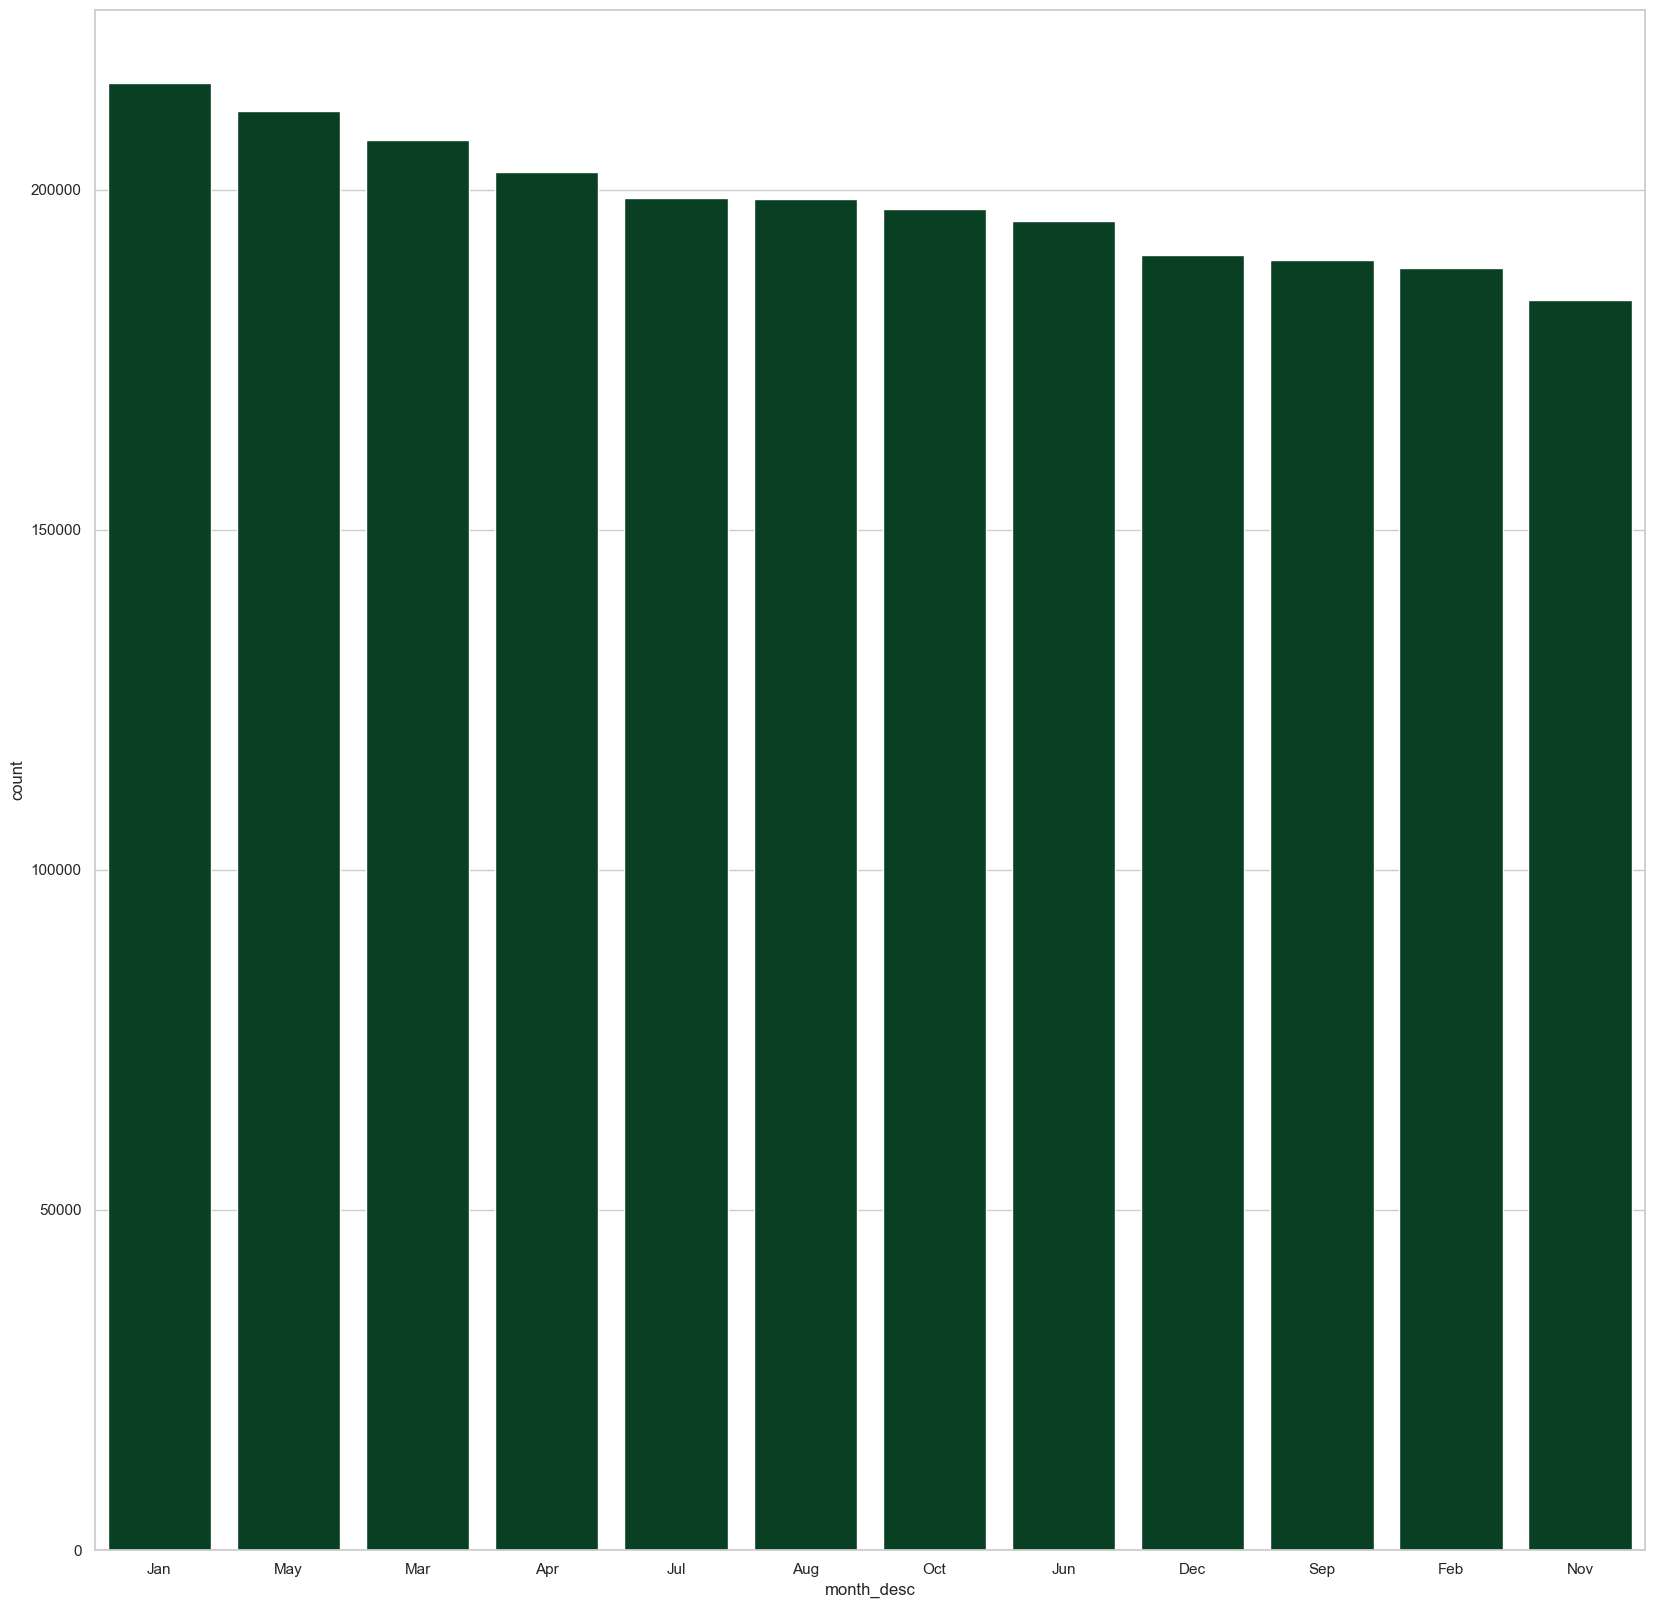

In [37]:
import calendar
cd['month_desc'] = cd['month'].map(lambda x: calendar.month_abbr[x])
plt.figure(figsize=(20, 20))
sns.countplot(data=cd, x='month_desc', order=cd['month_desc'].value_counts().index)

Interestingly, the amount of crimes is somewhat uniform throughout the year, with no particular month with an overwhelming difference to the rest

### CRIME RATE PER YEAR

year
2017    229695
2018    227605
2016    224213
2019    216114
2015    214296
2010    207771
2012    200340
2011    199341
2020    195235
2014    194357
2013    191529
2021     79244
Name: count, dtype: int64

<Figure size 2000x2000 with 0 Axes>

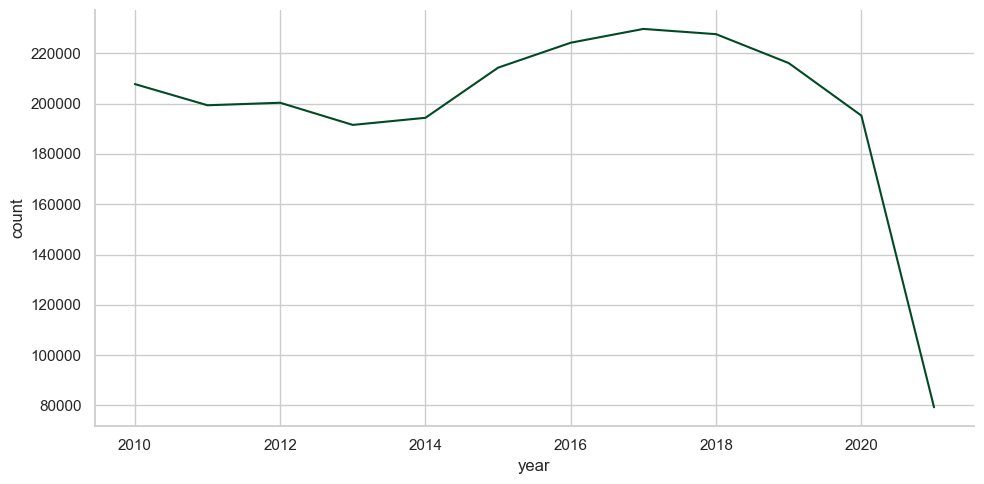

In [43]:
year_data = pd.DataFrame(cd['year'].value_counts())
year_data.rename(columns = {'year':'Count'}, inplace = True)

plt.figure(figsize=(20, 20))
sns.relplot(
    data=year_data, 
    x=year_data.index, y=cd['year'].value_counts(),
    height=5, aspect=2, 
    kind="line"
)
cd['year'].value_counts()

Since the data only goes as far as part of 2021, the discrepancy on the numbers for 2021 is justifiable. Otherwise, the 2016-2018 period saw the most amount of crime.

### VICTIM DATA

In [44]:
cd.loc[(cd["Vict Descent"] == 'H'),'Vict Descent']='Hispanic/Latin/Mexican'
cd.loc[(cd["Vict Descent"] == 'B'),'Vict Descent']='Black'
cd.loc[(cd["Vict Descent"] == 'W'),'Vict Descent']='White'
cd.loc[(cd["Vict Descent"] == 'A'),'Vict Descent']='Other Asian'
cd.loc[(cd["Vict Descent"] == 'X'),'Vict Descent']='Unknown'
cd.loc[(cd["Vict Descent"] == 'C'),'Vict Descent']='Chinese'
cd.loc[(cd["Vict Descent"] == 'D'),'Vict Descent']='Combodian'
cd.loc[(cd["Vict Descent"] == 'F'),'Vict Descent']='Filipino'
cd.loc[(cd["Vict Descent"] == 'G'),'Vict Descent']='Guamanian'
cd.loc[(cd["Vict Descent"] == 'I'),'Vict Descent']='America Indian/Alaskan Native'
cd.loc[(cd["Vict Descent"] == 'J'),'Vict Descent']='Japanese'
cd.loc[(cd["Vict Descent"] == 'K'),'Vict Descent']='Korean'
cd.loc[(cd["Vict Descent"] == 'L'),'Vict Descent']='Laotian'
cd.loc[(cd["Vict Descent"] == 'O'),'Vict Descent']='Other'
cd.loc[(cd["Vict Descent"] == 'S'),'Vict Descent']='Samoan'
cd.loc[(cd["Vict Descent"] == 'U'),'Vict Descent']='Hawaiian'
cd.loc[(cd["Vict Descent"] == 'V'),'Vict Descent']='Vietnamese'
cd.loc[(cd["Vict Descent"] == 'Z'),'Vict Descent']='Asian Indian'

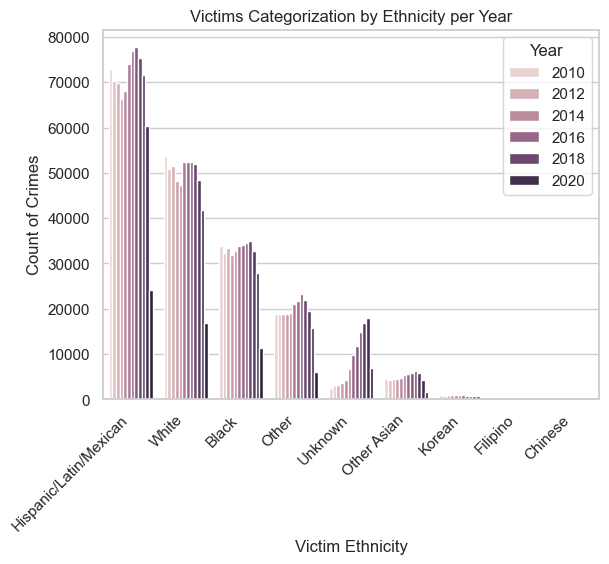

Vict Descent
Hispanic/Latin/Mexican           807422
White                            567759
Black                            373512
Other                            224049
Unknown                          101707
Other Asian                       57001
Korean                            10389
Filipino                           3376
Chinese                            1708
America Indian/Alaskan Native      1113
Japanese                            678
Vietnamese                          398
P                                   395
Hawaiian                            205
Asian Indian                        201
Guamanian                           107
Samoan                               43
Combodian                            34
Laotian                              26
-                                     3
Name: count, dtype: int64

In [49]:
sns.countplot(x='Vict Descent', hue='year', data=cd, order=cd['Vict Descent'].value_counts().index[:9])

plt.title('Victims Categorization by Ethnicity per Year')
plt.xlabel('Victim Ethnicity')
plt.ylabel('Count of Crimes')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Year')
plt.show()

cd['Vict Descent'].value_counts()

From the data shown, it seems that Hispanics compose the largest portion of the number of victims, followed by white descents and then Blacks. To do a more thorough conclusion, we would need to get the demographics of LA.

### THE 10 MOST COMMITED TYPES OF CRIMES IN LA BETWEEN 2010-2021

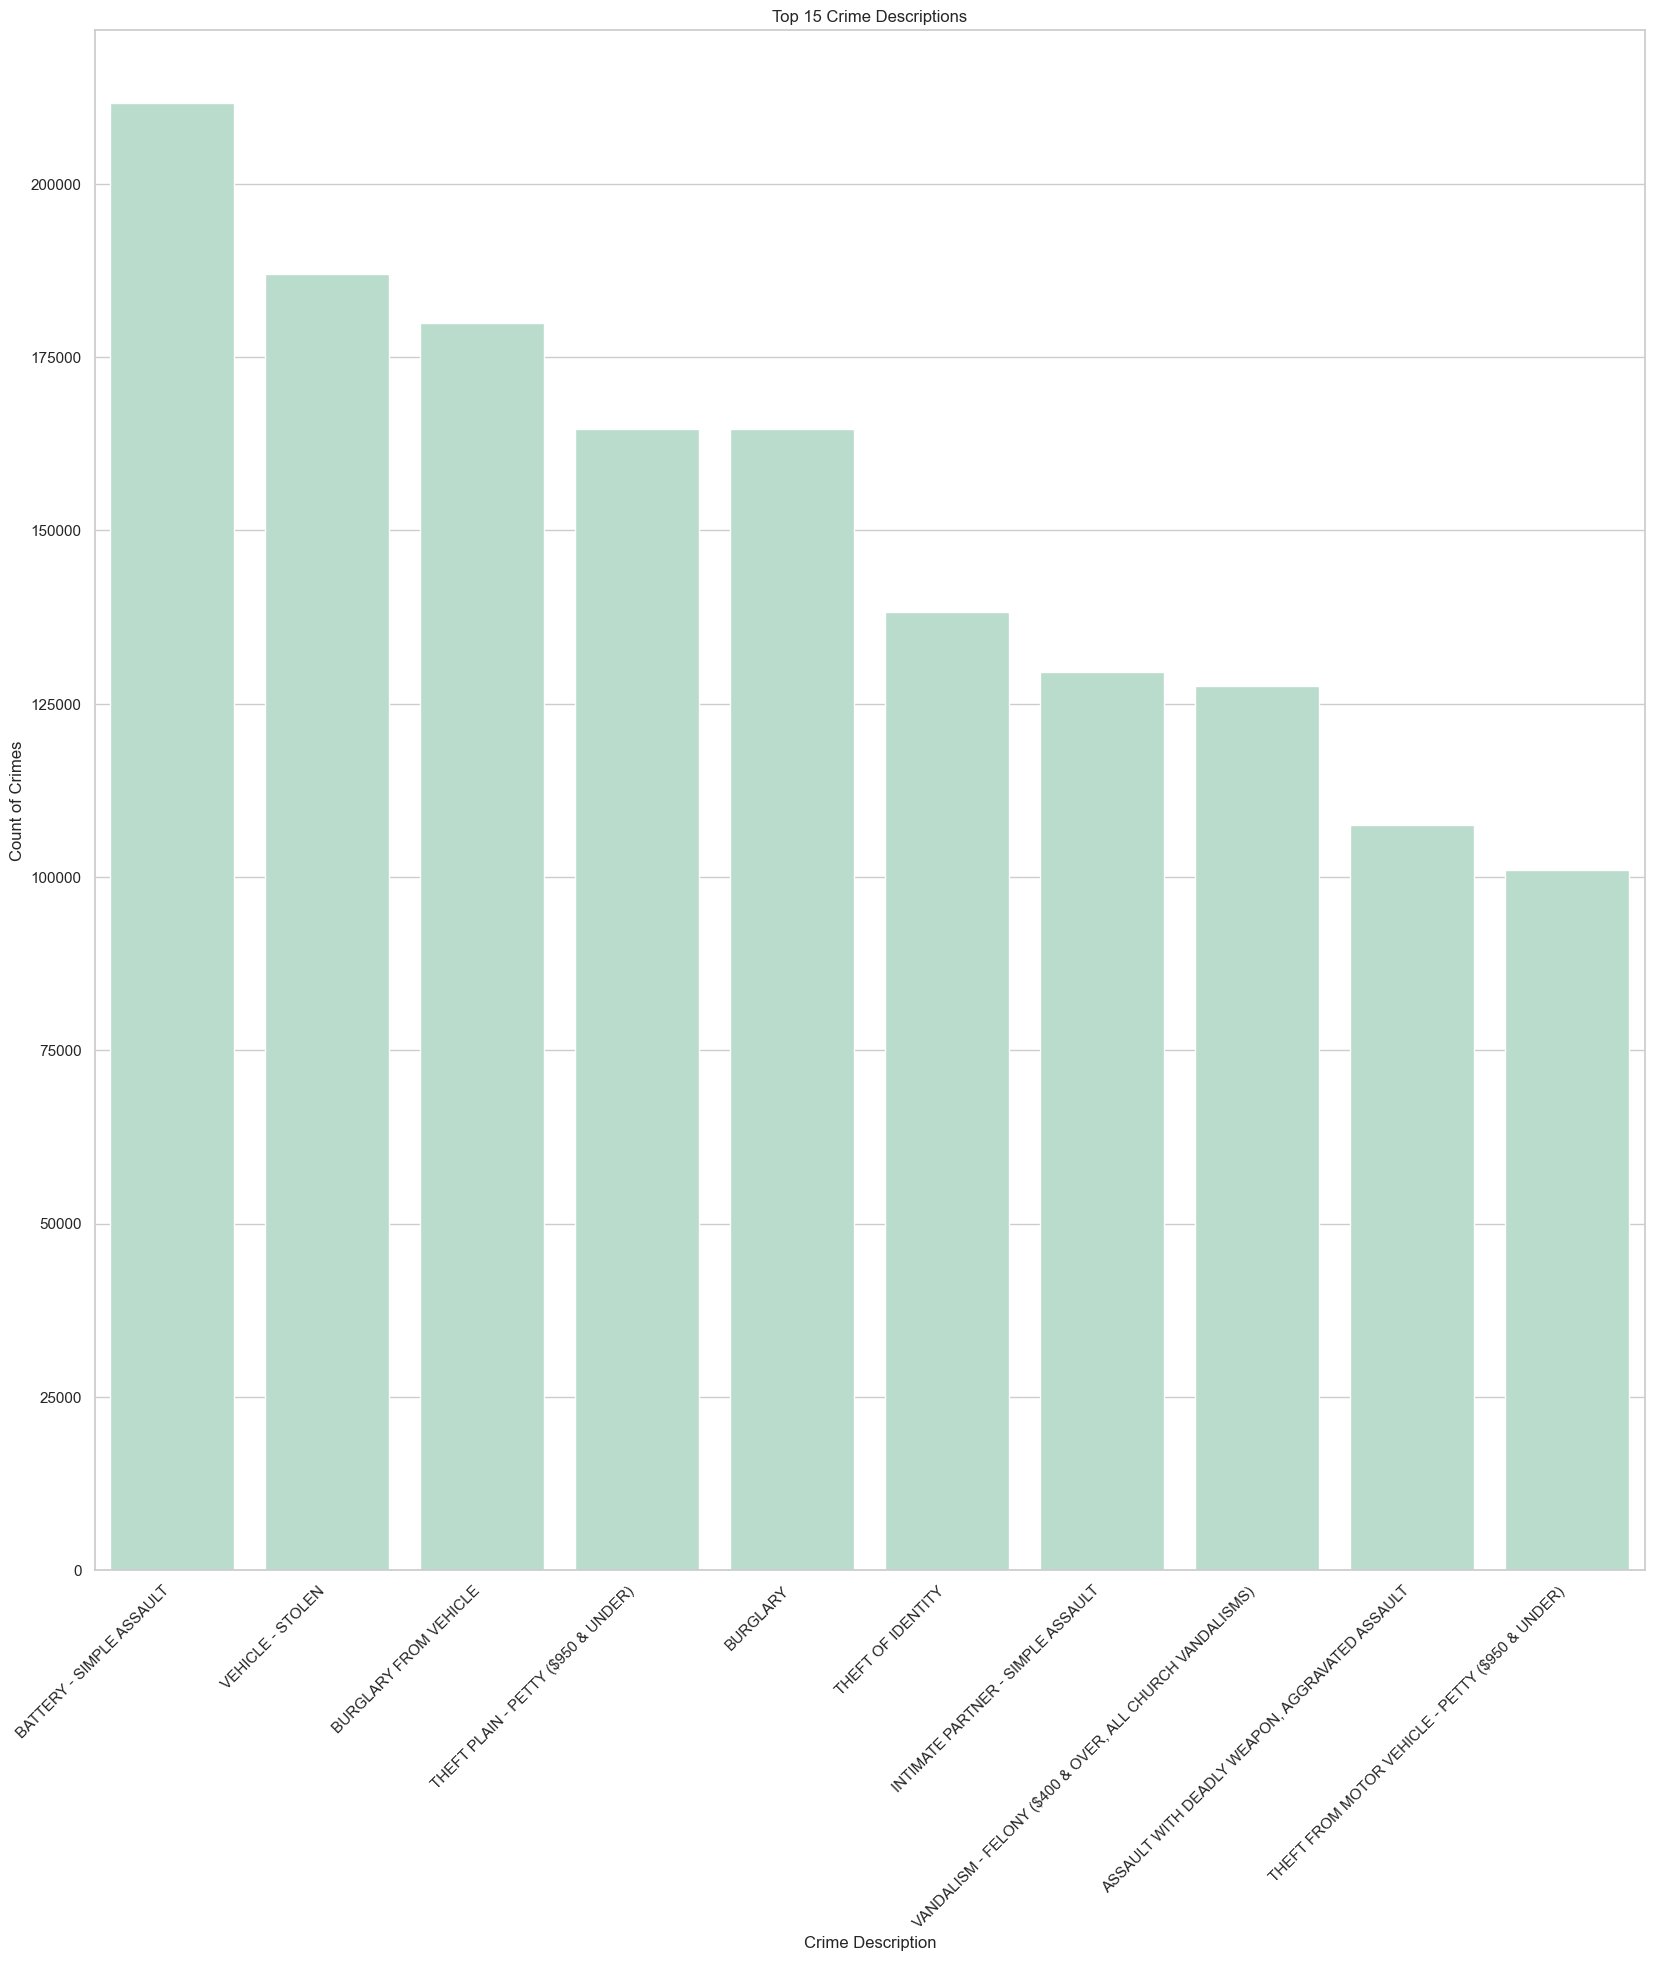

In [57]:
plt.figure(figsize=(20, 20))

sns.countplot(x='Crm Cd Desc', data=cd, order=cd['Crm Cd Desc'].value_counts().index[:10])

plt.title('Top 15 Crime Descriptions')
plt.xlabel('Crime Description')
plt.ylabel('Count of Crimes')

plt.xticks(rotation=45, ha='right')
plt.show()

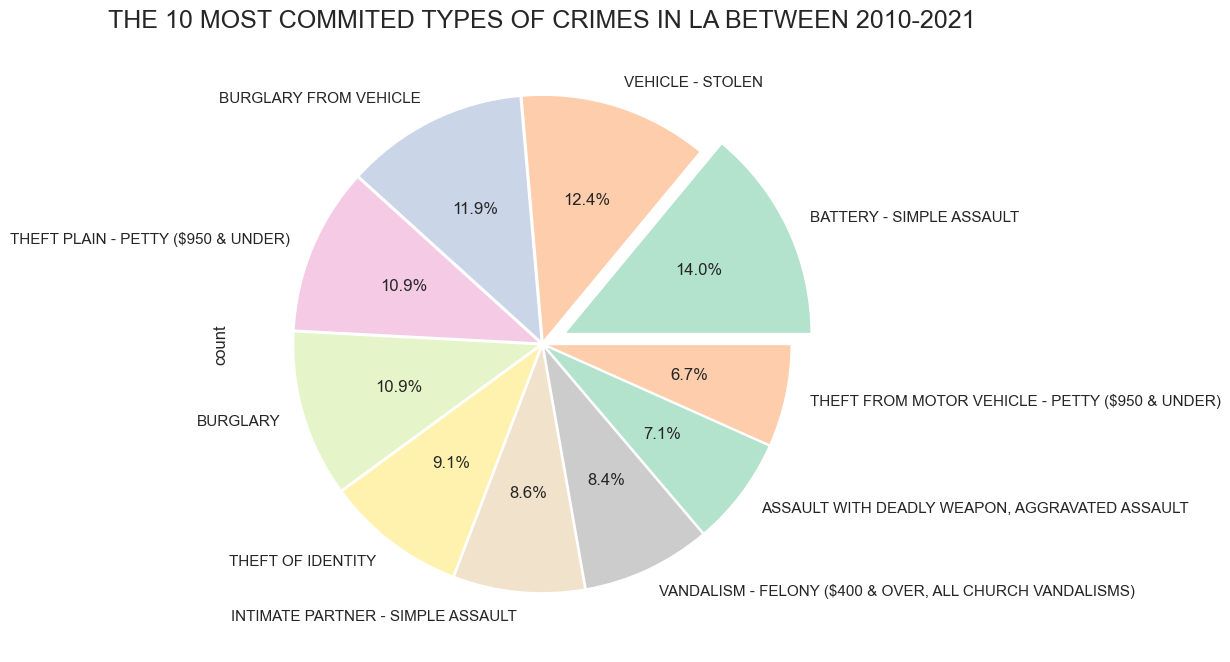

In [59]:
cd["Crm Cd Desc"].value_counts()[:10].plot.pie(figsize=(12,8),explode=(0.1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01),autopct="%1.1f%%")
plt.title("THE 10 MOST COMMITED TYPES OF CRIMES IN LA BETWEEN 2010-2021",fontsize=18)
plt.show()